<a href="https://colab.research.google.com/github/ryukir11/Tugas-Akhir/blob/main/CANADA_RIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from tensorflow.keras.optimizers import Adam
import math
import plotly.express as px
import plotly.figure_factory as ff
import yfinance as yf
import statsmodels.api as sm
from statistics import mode
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import kurtosis
import plotly.graph_objects as go
import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.dates as mdates
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
data = yf.download('^GSPTSE', start='2000-01-04', end='2024-04-30')

scaler = MinMaxScaler()
def scaling_data(data):
    features = [features for features in data.columns]
    data[features] = scaler.fit_transform(data[features])
    return data

data = scaling_data(data)
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price          Close      High       Low      Open    Volume
Ticker       ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE
Date                                                        
2000-01-04  0.150439  0.150477  0.150257  0.155512  0.063038
2000-01-05  0.145447  0.140898  0.141833  0.145184  0.100150
2000-01-06  0.145135  0.143264  0.145293  0.147401  0.084414
2000-01-07  0.164048  0.157968  0.152427  0.150797  0.092892
2000-01-10  0.174434  0.168881  0.171559  0.171929  0.088256
...              ...       ...       ...       ...       ...
2024-04-23  0.978994  0.980142  0.980334  0.975315  0.232004
2024-04-24  0.970714  0.978784  0.976861  0.981993  0.205578
2024-04-25  0.971416  0.972234  0.967255  0.970527  0.228175
2024-04-26  0.976444  0.976931  0.983564  0.976694  0.190953
2024-04-29  0.978988  0.980196  0.983297  0.982806  0.227815

[6110 rows x 5 columns]

In [ ]:
data2 = yf.download('^GSPTSE', start='2000-01-04', end='2024-04-30')
mini = data2['Close'].min()
max = data2['Close'].max()
price_range = max-mini
range_value = price_range.iloc[0]
range_value

[*********************100%***********************]  1 of 1 completed


np.float64(16666.5009765625)

In [ ]:
ret_df = data['Close']
def windowed_df(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][-1]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

In [ ]:
X, y, dates = windowed_df(ret_df, 5)

In [ ]:
data['Date'] = pd.to_datetime(data.index)

data.set_index('Date', inplace=True)

all_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

data_full = data.reindex(all_dates)

data_full = data_full.interpolate(method='linear')

data_full = data_full.reset_index()
data_full.rename(columns={'index': 'Date'}, inplace=True)
df = data_full.copy()
print(data_full)

Price        Date     Close      High       Low      Open    Volume
Ticker              ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE
0      2000-01-04  0.150439  0.150477  0.150257  0.155512  0.063038
1      2000-01-05  0.145447  0.140898  0.141833  0.145184  0.100150
2      2000-01-06  0.145135  0.143264  0.145293  0.147401  0.084414
3      2000-01-07  0.164048  0.157968  0.152427  0.150797  0.092892
4      2000-01-08  0.167510  0.161606  0.158804  0.157841  0.091346
...           ...       ...       ...       ...       ...       ...
8878   2024-04-25  0.971416  0.972234  0.967255  0.970527  0.228175
8879   2024-04-26  0.976444  0.976931  0.983564  0.976694  0.190953
8880   2024-04-27  0.977292  0.978019  0.983475  0.978731  0.203240
8881   2024-04-28  0.978140  0.979107  0.983386  0.980769  0.215528
8882   2024-04-29  0.978988  0.980196  0.983297  0.982806  0.227815

[8883 rows x 6 columns]


In [ ]:
def calculate_forward_trend_duration1(prices):
    n = len(prices)
    durations = [1] * n
    for i in range(n-1):
        count = 0
        j = i + 1

        if prices[j] > prices[i]:
            trend = "up"
        elif prices[j] < prices[i]:
            trend = "down"
        else:
            trend = "none"

        while j < n:
            if trend == "up" and prices[j] > prices[j - 1]:
                count += 1
            elif trend == "down" and prices[j] < prices[j - 1]:
                count += 1
            else:
                break
            j += 1

        durations[i] = count
    return durations

data_full['Trend_Duration'] = calculate_forward_trend_duration1(data_full['Close'].values)
print(data_full)

Price        Date     Close      High       Low      Open    Volume  \
Ticker              ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   
0      2000-01-04  0.150439  0.150477  0.150257  0.155512  0.063038   
1      2000-01-05  0.145447  0.140898  0.141833  0.145184  0.100150   
2      2000-01-06  0.145135  0.143264  0.145293  0.147401  0.084414   
3      2000-01-07  0.164048  0.157968  0.152427  0.150797  0.092892   
4      2000-01-08  0.167510  0.161606  0.158804  0.157841  0.091346   
...           ...       ...       ...       ...       ...       ...   
8878   2024-04-25  0.971416  0.972234  0.967255  0.970527  0.228175   
8879   2024-04-26  0.976444  0.976931  0.983564  0.976694  0.190953   
8880   2024-04-27  0.977292  0.978019  0.983475  0.978731  0.203240   
8881   2024-04-28  0.978140  0.979107  0.983386  0.980769  0.215528   
8882   2024-04-29  0.978988  0.980196  0.983297  0.982806  0.227815   

Price  Trend_Duration  
Ticker                 
0                   2  
1   

## LSTM MODEL

In [ ]:
data_full.index = data_full['Date']
data_full

Price            Date     Close      High       Low      Open    Volume  \
Ticker                  ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   
Date                                                                      
2000-01-04 2000-01-04  0.150439  0.150477  0.150257  0.155512  0.063038   
2000-01-05 2000-01-05  0.145447  0.140898  0.141833  0.145184  0.100150   
2000-01-06 2000-01-06  0.145135  0.143264  0.145293  0.147401  0.084414   
2000-01-07 2000-01-07  0.164048  0.157968  0.152427  0.150797  0.092892   
2000-01-08 2000-01-08  0.167510  0.161606  0.158804  0.157841  0.091346   
...               ...       ...       ...       ...       ...       ...   
2024-04-25 2024-04-25  0.971416  0.972234  0.967255  0.970527  0.228175   
2024-04-26 2024-04-26  0.976444  0.976931  0.983564  0.976694  0.190953   
2024-04-27 2024-04-27  0.977292  0.978019  0.983475  0.978731  0.203240   
2024-04-28 2024-04-28  0.978140  0.979107  0.983386  0.980769  0.215528   
2024-04-29 2024-04-29  0.978988  0.980196  0.983297  0.982806  0.227815   

Price      Trend_Duration  
Ticker                     
Date                       
2000-01-04              2  
2000-01-05              1  
2000-01-06              4  
2000-01-07              3  
2000-01-08              2  
...                   ...  
2024-04-25              4  
2024-04-26              3  
2024-04-27              2  
2024-04-28              1  
2024-04-29              1  

[8883 rows x 7 columns]

In [ ]:
#Sliding Window
X_close, y_close, dates_close = windowed_df(data_full['Close'], 5)
n_total = len(X_close)
Mq_80 = int(n_total*0.8)
Mq_90 = int(n_total*0.9)
dates_train, X_train, y_train = dates_close[:Mq_80], X_close[:Mq_80], y_close[:Mq_80]
dates_val, X_val, y_val = dates_close[Mq_80:Mq_90], X_close[Mq_80:Mq_90], y_close[Mq_80:Mq_90]
dates_test, X_test, y_test = dates_close[Mq_90:], X_close[Mq_90:], y_close[Mq_90:]

In [ ]:
data_full.iloc[7101:7106]

Price            Date     Close      High       Low      Open    Volume  \
Ticker                  ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   ^GSPTSE   
Date                                                                      
2019-06-14 2019-06-14  0.636402  0.634533  0.637112  0.634666  0.180347   
2019-06-15 2019-06-15  0.637434  0.635231  0.639043  0.636144  0.185638   
2019-06-16 2019-06-16  0.638466  0.635929  0.640974  0.637621  0.190928   
2019-06-17 2019-06-17  0.639498  0.636628  0.642906  0.639099  0.196219   
2019-06-18 2019-06-18  0.648492  0.646720  0.652742  0.648120  0.231933   

Price      Trend_Duration  
Ticker                     
Date                       
2019-06-14              6  
2019-06-15              5  
2019-06-16              4  
2019-06-17              3  
2019-06-18              2

In [ ]:
X_train[7101]

array([[0.63640236],
       [0.63743436],
       [0.63846637],
       [0.63949837],
       [0.64849248]])

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
print(np.min(y_train))  # Harusnya > 0 kalau mau MAPE aman
print(np.sum(y_train == 0))

0.0
1


In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (5,1)),
    layers.Dropout(0.3),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

## CLOSE

In [ ]:
result = []
train_pred = []
val_pred = []
test_pred = []
histories = []
train_mapes = []
val_mapes = []
test_mapes = []

for i in range(30):
    print(f"\nTraining iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    checkpoint_path = f'best_weights_iter_{i+1}.weights.h5'
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta= 0.0001,
        patience=20,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        batch_size=128,
        validation_data=(X_val, y_val),
        epochs=200,
        callbacks=[checkpoint],
        verbose=0
    )

    result.append(history)
    histories.append(history.history)

    model.load_weights(checkpoint_path)

    train = model.predict(X_train, verbose=0).flatten()
    val = model.predict(X_val, verbose=0).flatten()
    test = model.predict(X_test, verbose=0).flatten()

    train_pred.append(train)
    val_pred.append(val)
    test_pred.append(test)

    mape_train = mean_absolute_percentage_error(y_train, train)
    mape_val = mean_absolute_percentage_error(y_val, val)
    mape_test = mean_absolute_percentage_error(y_test, test)

    train_mapes.append(mape_train)
    val_mapes.append(mape_val)
    test_mapes.append(mape_test)

    print(f"Iteration {i+1} - MAPE Train: {mape_train:.4f}, Val: {mape_val:.4f}, Test: {mape_test:.4f}")


Training iteration 1...
Iteration 1 - MAPE Train: 29305449678.2454, Val: 0.0598, Test: 0.0659

Training iteration 2...
Iteration 2 - MAPE Train: 20360443806.5765, Val: 0.0711, Test: 0.1429

Training iteration 3...
Iteration 3 - MAPE Train: 46929553650.8742, Val: 0.0279, Test: 0.0176

Training iteration 4...
Iteration 4 - MAPE Train: 33824407690.4783, Val: 0.0623, Test: 0.0768

Training iteration 5...
Iteration 5 - MAPE Train: 28472527757.5672, Val: 0.0604, Test: 0.0755

Training iteration 6...
Iteration 6 - MAPE Train: 35232940253.5222, Val: 0.0723, Test: 0.1107

Training iteration 7...
Iteration 7 - MAPE Train: 28305813918.1480, Val: 0.0687, Test: 0.0866

Training iteration 8...
Iteration 8 - MAPE Train: 34157282585.8000, Val: 0.0411, Test: 0.0317

Training iteration 9...
Iteration 9 - MAPE Train: 44524567376.4755, Val: 0.0775, Test: 0.1063

Training iteration 10...
Iteration 10 - MAPE Train: 48982232563.2388, Val: 0.0239, Test: 0.0195

Training iteration 11...
Iteration 11 - MAPE Tr

In [ ]:
best_index = np.argmin(val_mapes)
print(f"\nBest iteration: {best_index+1}")
print(f"Val MAPE: {val_mapes[best_index]:.4f}, Test MAPE: {test_mapes[best_index]:.4f}")


Best iteration: 10
Val MAPE: 0.0239, Test MAPE: 0.0195


In [ ]:
model.load_weights(f'best_weights_iter_{best_index+1}.weights.h5')

In [ ]:
train_df = pd.DataFrame(train_pred).transpose()
val_df = pd.DataFrame(val_pred).transpose()
test_df = pd.DataFrame(test_pred).transpose()

train_df.columns = [f'Iterasi {i+1}' for i in range(train_df.shape[1])]
val_df.columns = [f'Iterasi {i+1}' for i in range(val_df.shape[1])]
test_df.columns = [f'Iterasi {i+1}' for i in range(test_df.shape[1])]

train_df['Rata2'] = train_df.mean(axis=1)
val_df['Rata2'] = val_df.mean(axis=1)
test_df['Rata2'] = test_df.mean(axis=1)

train_df.index = dates_train
val_df.index = dates_val
test_df.index = dates_test

In [ ]:
train_df = train_df.multiply(range_value)
train_df.to_csv('hasiltrainlstm_INDO.csv')
train_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2000-01-09   2516.763672   2581.130859   2349.915771   2477.127197   
2000-01-10   2552.515869   2605.234863   2400.757080   2522.902588   
2000-01-11   2645.255371   2695.736572   2530.830078   2628.820312   
2000-01-12   2772.911865   2850.380371   2696.728027   2757.079590   
2000-01-13   2794.205566   2880.677246   2724.003906   2776.752930   
...                  ...           ...           ...           ...   
2019-06-15  10039.165039  10412.091797  10295.268555  10067.176758   
2019-06-16  10052.804688  10421.206055  10310.682617  10080.746094   
2019-06-17  10063.296875  10427.813477  10322.246094  10090.240234   
2019-06-18  10086.406250  10441.218750  10347.611328  10111.148438   
2019-06-19  10120.130859  10462.461914  10384.971680  10143.986328   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2000-01-09   2547.839844   2485.246338   2495.048828   2559.211182   
2000-01-10   2593.309814   2523.248535   2537.381104   2603.171631   
2000-01-11   2702.111816   2636.191162   2638.111816   2703.435547   
2000-01-12   2831.633545   2794.355957   2759.950928   2824.438721   
2000-01-13   2852.283936   2825.013184   2779.176514   2842.421631   
...                  ...           ...           ...           ...   
2019-06-15  10093.975586  10119.156250  10018.723633  10171.342773   
2019-06-16  10107.529297  10130.387695  10031.308594  10186.869141   
2019-06-17  10117.558594  10139.328125  10040.779297  10197.222656   
2019-06-18  10138.322266  10157.171875  10060.655273  10221.947266   
2019-06-19  10170.543945  10184.019531  10090.947266  10259.860352   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2000-01-09   2664.299072   2623.503662  ...   2663.857666   2445.119385   
2000-01-10   2702.218018   2665.390381  ...   2703.292725   2484.028564   
2000-01-11   2788.457275   2762.526855  ...   2791.585938   2591.412598   
2000-01-12   2894.066162   2886.959473  ...   2897.567871   2730.566162   
2000-01-13   2910.186035   2906.137695  ...   2913.185791   2752.750732   
...                  ...           ...  ...           ...           ...   
2019-06-15   9975.850586  10343.309570  ...  10117.785156  10222.167969   
2019-06-16   9989.193359  10358.235352  ...  10130.715820  10239.531250   
2019-06-17   9997.375000  10368.372070  ...  10139.819336  10250.561523   
2019-06-18  10016.818359  10394.004883  ...  10160.201172  10276.912109   
2019-06-19  10048.122070  10431.060547  ...  10191.220703  10318.166016   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2000-01-09   2420.802490   2674.660889   2609.747803   2456.260254   
2000-01-10   2467.864258   2717.367676   2653.459717   2494.631592   
2000-01-11   2571.185547   2826.283203   2740.223145   2590.433838   
2000-01-12   2694.494141   2975.277100   2836.052246   2710.119629   
2000-01-13   2713.035889   2985.290039   2846.686768   2729.542480   
...                  ...           ...           ...           ...   
2019-06-15  10159.029297  10390.761719  10075.389648  10092.833008   
2019-06-16  10172.587891  10404.055664  10090.166992  10104.513672   
2019-06-17  10182.661133  10414.246094  10102.074219  10115.250000   
2019-06-18  10205.028320  10435.991211  10125.286133  10134.001953   
2019-06-19  10238.349609  10468.089844  10161.187500  10161.246094   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2000-01-09   2432.654297   2475.082520   2498.959961   2533.611572  
2000-01-10   2477.277832   2520.522217   2538.922852   2575.007812  
2000-01-11   2581.872070   2632.864746   2641.886963   2675.884766  
2000-01-12   2710.349121   2777.907715   2771.221191   2804.130859  
2000-01-13   2730.351074   2802.069336   2792.554199   2823.793945  
...                  ...           ...           ...           ...  
2019-06-15  10254.656250  10298.856445  10290.891602  10154.334961  
2019-06-16  10271.861328  10315.416992 

In [ ]:
print(np.min(train_df))

457.17498779296875


In [ ]:
val_df = val_df.multiply(range_value)
val_df.to_csv('hasilvallstm_INDO.csv')
val_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2019-06-20  10148.398438  10479.724609  10416.901367  10171.000977   
2019-06-21  10187.270508  10502.384766  10459.530273  10206.807617   
2019-06-22  10231.522461  10527.316406  10508.208984  10246.184570   
2019-06-23  10278.688477  10553.548828  10560.483398  10290.883789   
2019-06-24  10286.978516  10557.760742  10569.136719  10297.693359   
...                  ...           ...           ...           ...   
2021-11-19  14993.822266  13302.783203  16120.359375  14795.518555   
2021-11-20  14972.346680  13290.089844  16094.743164  14774.598633   
2021-11-21  14947.697266  13275.375000  16065.455078  14750.034180   
2021-11-22  14895.990234  13245.703125  16002.410156  14699.689453   
2021-11-23  14849.869141  13219.061523  15946.171875  14654.446289   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2019-06-20  10198.179688  10207.620117  10116.666992  10290.894531   
2019-06-21  10234.261719  10238.527344  10151.141602  10331.776367   
2019-06-22  10273.176758  10272.156250  10188.711914  10378.985352   
2019-06-23  10315.398438  10306.757812  10229.886719  10432.670898   
2019-06-24  10321.837891  10312.281250  10236.188477  10441.562500   
...                  ...           ...           ...           ...   
2021-11-19  14779.532227  14069.290039  14638.682617  15699.244141   
2021-11-20  14758.325195  14051.755859  14617.286133  15674.658203   
2021-11-21  14733.513672  14031.203125  14592.429688  15646.230469   
2021-11-22  14684.839844  13990.141602  14542.126953  15587.210938   
2021-11-23  14640.990234  13953.230469  14496.900391  15534.344727   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2019-06-20  10073.606445  10461.220703  ...  10217.238281  10351.877930   
2019-06-21  10106.877930  10502.533203  ...  10251.780273  10396.521484   
2019-06-22  10143.418945  10552.692383  ...  10290.551758  10446.653320   
2019-06-23  10186.532227  10609.842773  ...  10334.093750  10504.373047   
2019-06-24  10192.635742  10619.692383  ...  10340.942383  10513.176758   
...                  ...           ...  ...           ...           ...   
2021-11-19  14222.834961  16462.597656  ...  14669.913086  16325.686523   
2021-11-20  14203.907227  16436.515625  ...  14649.916016  16298.037109   
2021-11-21  14181.803711  16407.970703  ...  14626.886719  16266.131836   
2021-11-22  14137.178711  16338.959961  ...  14578.647461  16199.208008   
2021-11-23  14097.042969  16278.230469  ...  14535.482422  16139.324219   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2019-06-20  10266.574219  10495.818359  10192.215820  10185.342773   
2019-06-21  10303.540039  10532.687500  10232.955078  10215.699219   
2019-06-22  10345.203125  10574.322266  10276.131836  10246.903320   
2019-06-23  10390.107422  10618.518555  10320.413086  10279.089844   
2019-06-24  10397.323242  10625.768555  10327.425781  10284.027344   
...                  ...           ...           ...           ...   
2021-11-19  14872.500000  15302.358398  15406.201172  13775.827148   
2021-11-20  14852.019531  15280.696289  15381.433594  13758.849609   
2021-11-21  14828.562500  15253.653320  15352.333984  13738.796875   
2021-11-22  14780.342773  15200.896484  15295.268555  13700.584961   
2021-11-23  14737.201172  15152.456055  15243.835938  13666.045898   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2019-06-20  10388.894531  10429.931641  10424.158203  10258.928711  
2019-06-21  10435.725586  10475.789062  10470.682617  10295.030273  
2019-06-22  10487.214844  10528.221680  10522.570312  10335.070312  
2019-06-23  10542.200195  10584.972656  10579.273438  10378.589844  
2019-06-24  10550.894531  10594.488281  10588.211914  10385.506836  
...                  ...           ...           ...           ...  
2021-11-19  16574.429688  16848.169922  16697.371094  14923.803711  
2021-11-20  16545.232422  16818.023438 

In [ ]:
test_df = test_df.multiply(range_value)
test_df.to_csv('hasiltestlstm_INDO.csv')
test_df

Iterasi 1     Iterasi 2     Iterasi 3     Iterasi 4  \
2021-11-24  14798.078125  13189.829102  15882.210938  14604.186523   
2021-11-25  14773.600586  13176.665039  15851.205078  14580.512695   
2021-11-26  14772.176758  13176.799805  15847.757812  14579.577148   
2021-11-27  14762.411133  13169.077148  15836.959961  14570.503906   
2021-11-28  14743.559570  13156.385742  15817.812500  14551.514648   
...                  ...           ...           ...           ...   
2024-04-25  15178.577148  13410.006836  16343.994141  14976.319336   
2024-04-26  15202.490234  13423.074219  16373.853516  14999.617188   
2024-04-27  15225.711914  13436.481445  16403.306641  15022.145508   
2024-04-28  15248.808594  13449.500977  16431.517578  15043.694336   
2024-04-29  15228.254883  13438.619141  16404.576172  15024.770508   

               Iterasi 5     Iterasi 6     Iterasi 7     Iterasi 8  \
2021-11-24  14593.666992  13912.868164  14447.380859  15475.383789   
2021-11-25  14572.922852  13894.672852  14424.479492  15447.692383   
2021-11-26  14574.266602  13895.058594  14424.319336  15446.190430   
2021-11-27  14560.478516  13885.000000  14413.259766  15434.031250   
2021-11-28  14537.608398  13867.034180  14394.177734  15412.717773   
...                  ...           ...           ...           ...   
2024-04-25  14957.088867  14217.965820  14820.055664  15910.943359   
2024-04-26  14978.216797  14236.146484  14843.647461  15938.199219   
2024-04-27  14999.875977  14254.516602  14865.834961  15965.270508   
2024-04-28  15020.854492  14272.195312  14887.068359  15991.201172   
2024-04-29  15004.331055  14257.562500  14869.133789  15967.968750   

               Iterasi 9    Iterasi 10  ...    Iterasi 22    Iterasi 23  \
2021-11-24  14052.959961  16205.251953  ...  14487.105469  16072.194336   
2021-11-25  14032.771484  16166.944336  ...  14464.217773  16040.236328   
2021-11-26  14032.720703  16157.153320  ...  14462.700195  16037.922852   
2021-11-27  14022.496094  16151.285156  ...  14453.105469  16025.449219   
2021-11-28  14004.233398  16142.439453  ...  14436.277344  16002.767578   
...                  ...           ...  ...           ...           ...   
2024-04-25  14383.970703  16700.263672  ...  14842.182617  16565.177734   
2024-04-26  14404.053711  16735.464844  ...  14864.566406  16596.396484   
2024-04-27  14424.041016  16769.970703  ...  14886.641602  16627.076172   
2024-04-28  14443.245117  16802.853516  ...  14907.881836  16656.531250   
2024-04-29  14427.041016  16766.072266  ...  14888.622070  16629.757812   

              Iterasi 24    Iterasi 25    Iterasi 26    Iterasi 27  \
2021-11-24  14689.437500  15099.930664  15188.293945  13629.383789   
2021-11-25  14667.565430  15075.057617  15163.773438  13613.844727   
2021-11-26  14667.166992  15074.429688  15165.239258  13615.913086   
2021-11-27  14655.322266  15065.842773  15149.993164  13604.091797   
2021-11-28  14636.186523  15046.118164  15123.397461  13584.056641   
...                  ...           ...           ...           ...   
2024-04-25  15045.567383  15494.177734  15614.437500  13916.448242   
2024-04-26  15067.245117  15519.050781  15639.447266  13932.555664   
2024-04-27  15088.957031  15543.461914  15664.712891  13949.179688   
2024-04-28  15110.316406  15563.333984  15689.147461  13965.405273   
2024-04-29  15092.012695  15545.466797  15669.859375  13953.595703   

              Iterasi 28    Iterasi 29    Iterasi 30         Rata2  
2021-11-24  16313.492188  16570.798828  16427.873047  14730.608398  
2021-11-25  16282.793945  16535.150391  16394.597656  14707.238281  
2021-11-26  16282.931641  16531.248047  16393.128906  14706.589844  
2021-11-27  16266.573242  16516.585938  16379.943359  14695.356445  
2021-11-28  16238.034180  16494.498047  16353.443359  14675.670898  
...                  ...           ...           ...           ...  
2024-04-25  16822.724609  17109.576172  16952.699219  15106.840820  
2024-04-26  16853.568359  17144.378906 

In [ ]:
traincopy = train_df.copy()
valcopy = val_df.copy()
testcopy = test_df.copy()

## IMPORT

In [ ]:
traincopy = pd.read_csv('hasiltrainlstm_INDO.csv')
valcopy = pd.read_csv('hasilvallstm_INDO.csv')
testcopy = pd.read_csv('hasiltestlstm_INDO.csv')

In [ ]:
traincopy.index = traincopy['Unnamed: 0']
valcopy.index = valcopy['Unnamed: 0']
testcopy.index = testcopy['Unnamed: 0']

In [ ]:
traincopy = traincopy.drop(columns=['Unnamed: 0'])
valcopy = valcopy.drop(columns=['Unnamed: 0'])
testcopy = testcopy.drop(columns=['Unnamed: 0'])

In [ ]:
train_df = traincopy.copy()
val_df = valcopy.copy()
test_df = testcopy.copy()

## MAPE

In [ ]:
X_train.shape, X_val.shape, X_test.shape

((7102, 5, 1), (888, 5, 1), (888, 5, 1))

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((7102,), (888,), (888,))

In [ ]:
y_test2 = y_test*range_value
y_train2 = y_train*range_value
y_val2 = y_val*range_value
print(y_train2)

[ 2849.50032552  2907.20019531  2747.29980469 ... 10658.20019531
 10808.10058594 10816.50097656]


In [ ]:
y_train2 = y_train*range_value

In [ ]:
from math import sqrt
prediction = testcopy['Rata2']
close_test_mae = mean_absolute_error(y_test2, prediction)
close_test_mse = mean_squared_error(y_test2, prediction)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, prediction)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

(1012.8212607685809,
 1089674.9343098036,
 1043.8749610512764,
 0.0688924108694926)

In [ ]:
val_result = valcopy['Rata2']
close_val_mae = mean_absolute_error(y_val2, val_result)
close_val_mse = mean_squared_error(y_val2, val_result)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val2, val_result)
close_val_mae, close_val_mse, close_val_rmse, close_val_mape

(673.1785505912161, 555181.4944575373, 745.1050224347822, 0.05554774129881175)

In [ ]:
train_result = traincopy['Rata2']
y_train2[y_train == 0] = mini
close_train_mae = mean_absolute_error(y_train2, train_result)
close_train_mse = mean_squared_error(y_train2, train_result)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train2, train_result)
close_train_mae, close_train_mse, close_train_rmse, close_train_mape

(191.28186815747316,
 59035.966411417336,
 242.9731804364781,
 0.058784480031214274)

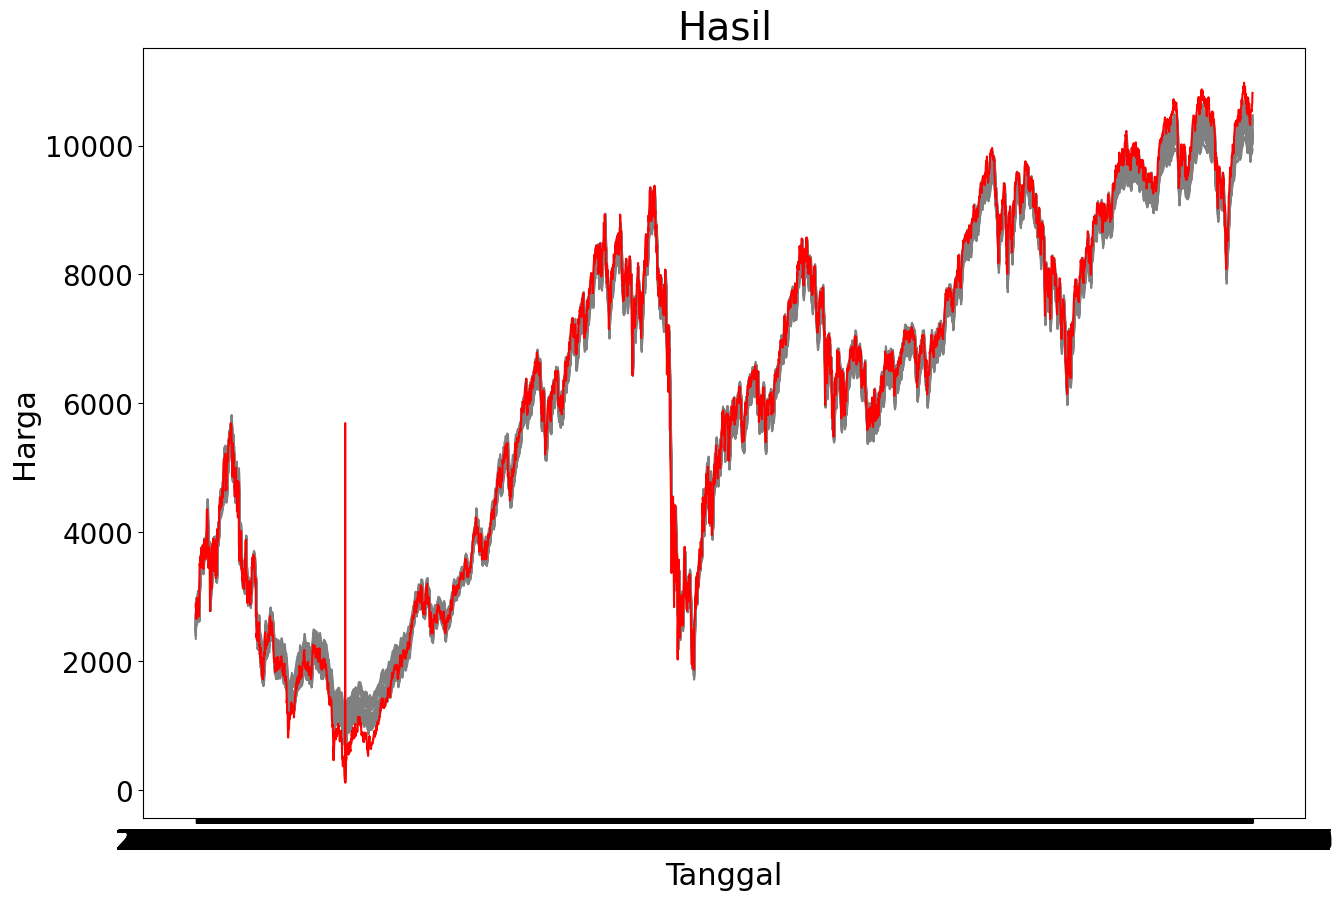

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in traincopy.columns:
  if column != 'Rata2':
    ax.plot(traincopy.index, traincopy[column], label='Prediksi', color='gray')
ax.plot(traincopy.index, y_train2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

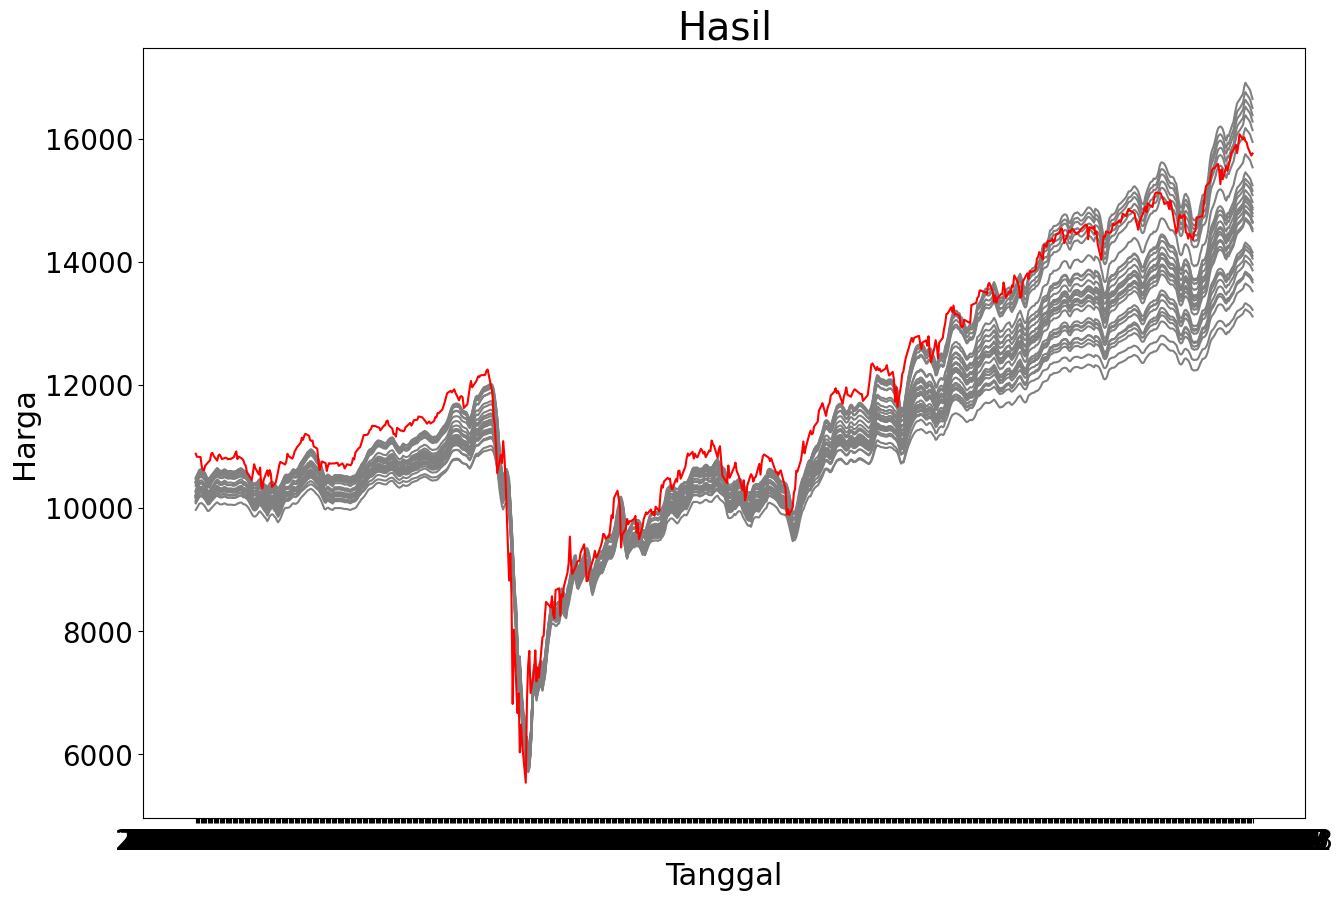

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in val_df.columns:
  if column != 'Rata2':
    ax.plot(val_df.index, val_df[column], label='Prediksi', color='gray')
ax.plot(val_df.index, y_val2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

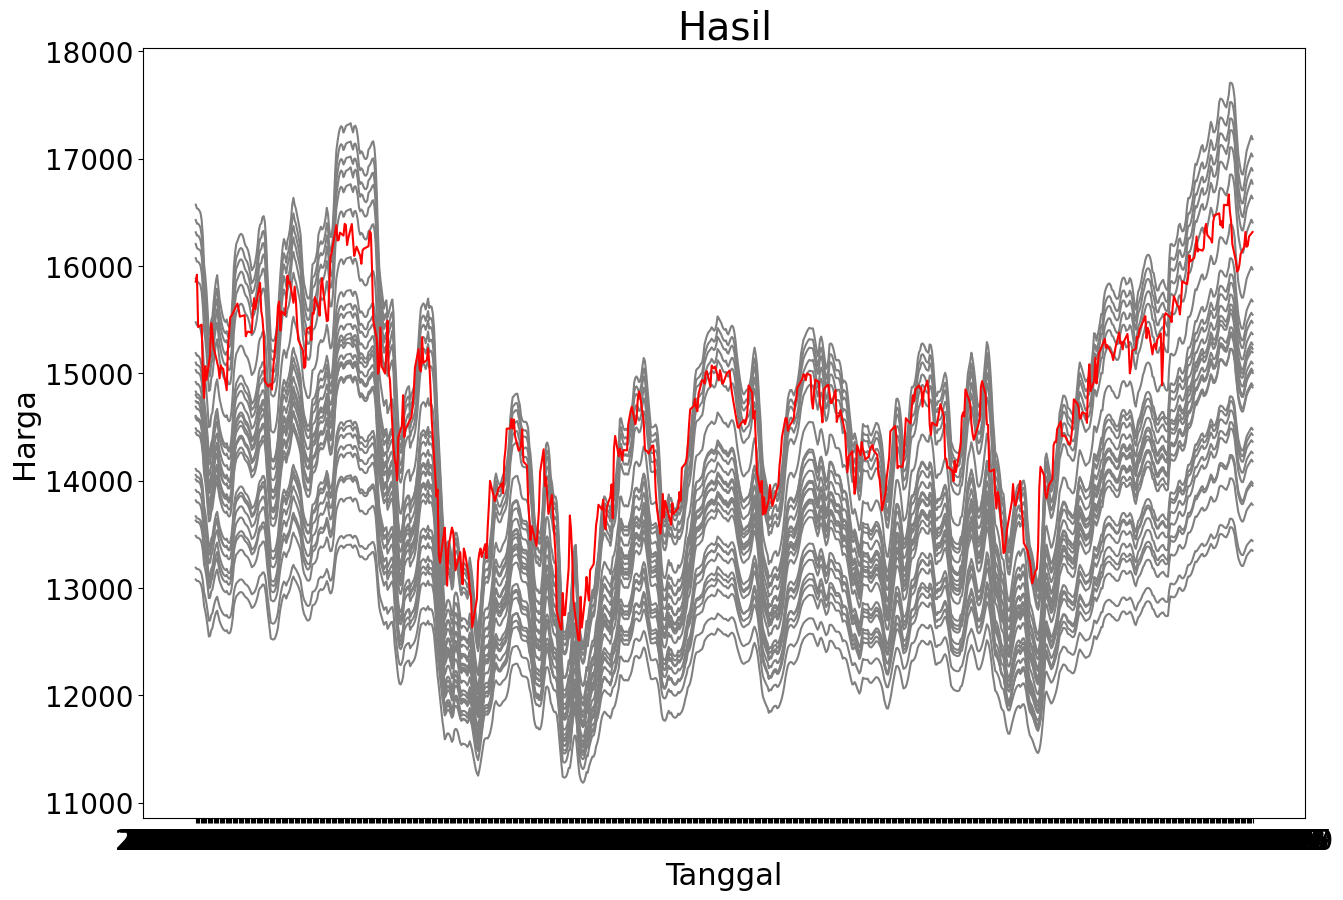

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in test_df.columns:
  if column != 'Rata2':
    ax.plot(test_df.index, test_df[column], label='Prediksi', color='gray')
ax.plot(test_df.index, y_test2, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## Model Hybrid

In [ ]:
traincnn = train_df['Rata2']
valcnn = val_df['Rata2']
testcnn = test_df['Rata2']

traincnn = pd.DataFrame(traincnn)
valcnn = pd.DataFrame(valcnn)
testcnn = pd.DataFrame(testcnn)

traincnn.columns = ['Close']
valcnn.columns = ['Close']
testcnn.columns = ['Close']

traincnn = traincnn.divide(range_value)
valcnn = valcnn.divide(range_value)
testcnn = testcnn.divide(range_value)
traincnn.shape, valcnn.shape, testcnn.shape, df.shape

((7102, 1), (888, 1), (888, 1), (8883, 6))

In [ ]:
padding = traincnn[:2]
df = pd.concat([padding, traincnn, valcnn, testcnn])
df.reset_index(drop=True, inplace=True)
df

Close
0     0.152018
1     0.154502
2     0.152018
3     0.154502
4     0.160555
...        ...
8875  0.906419
8876  0.907809
8877  0.909195
8878  0.910525
8879  0.909367

[8880 rows x 1 columns]

In [ ]:
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_200']= df['Close'].ewm(span=200, adjust=False).mean()
df['Diff'] = df['EMA_50']-df['EMA_200']
df['sign'] = df['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
df['sign_change'] = df['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = df[df['sign_change']==1]

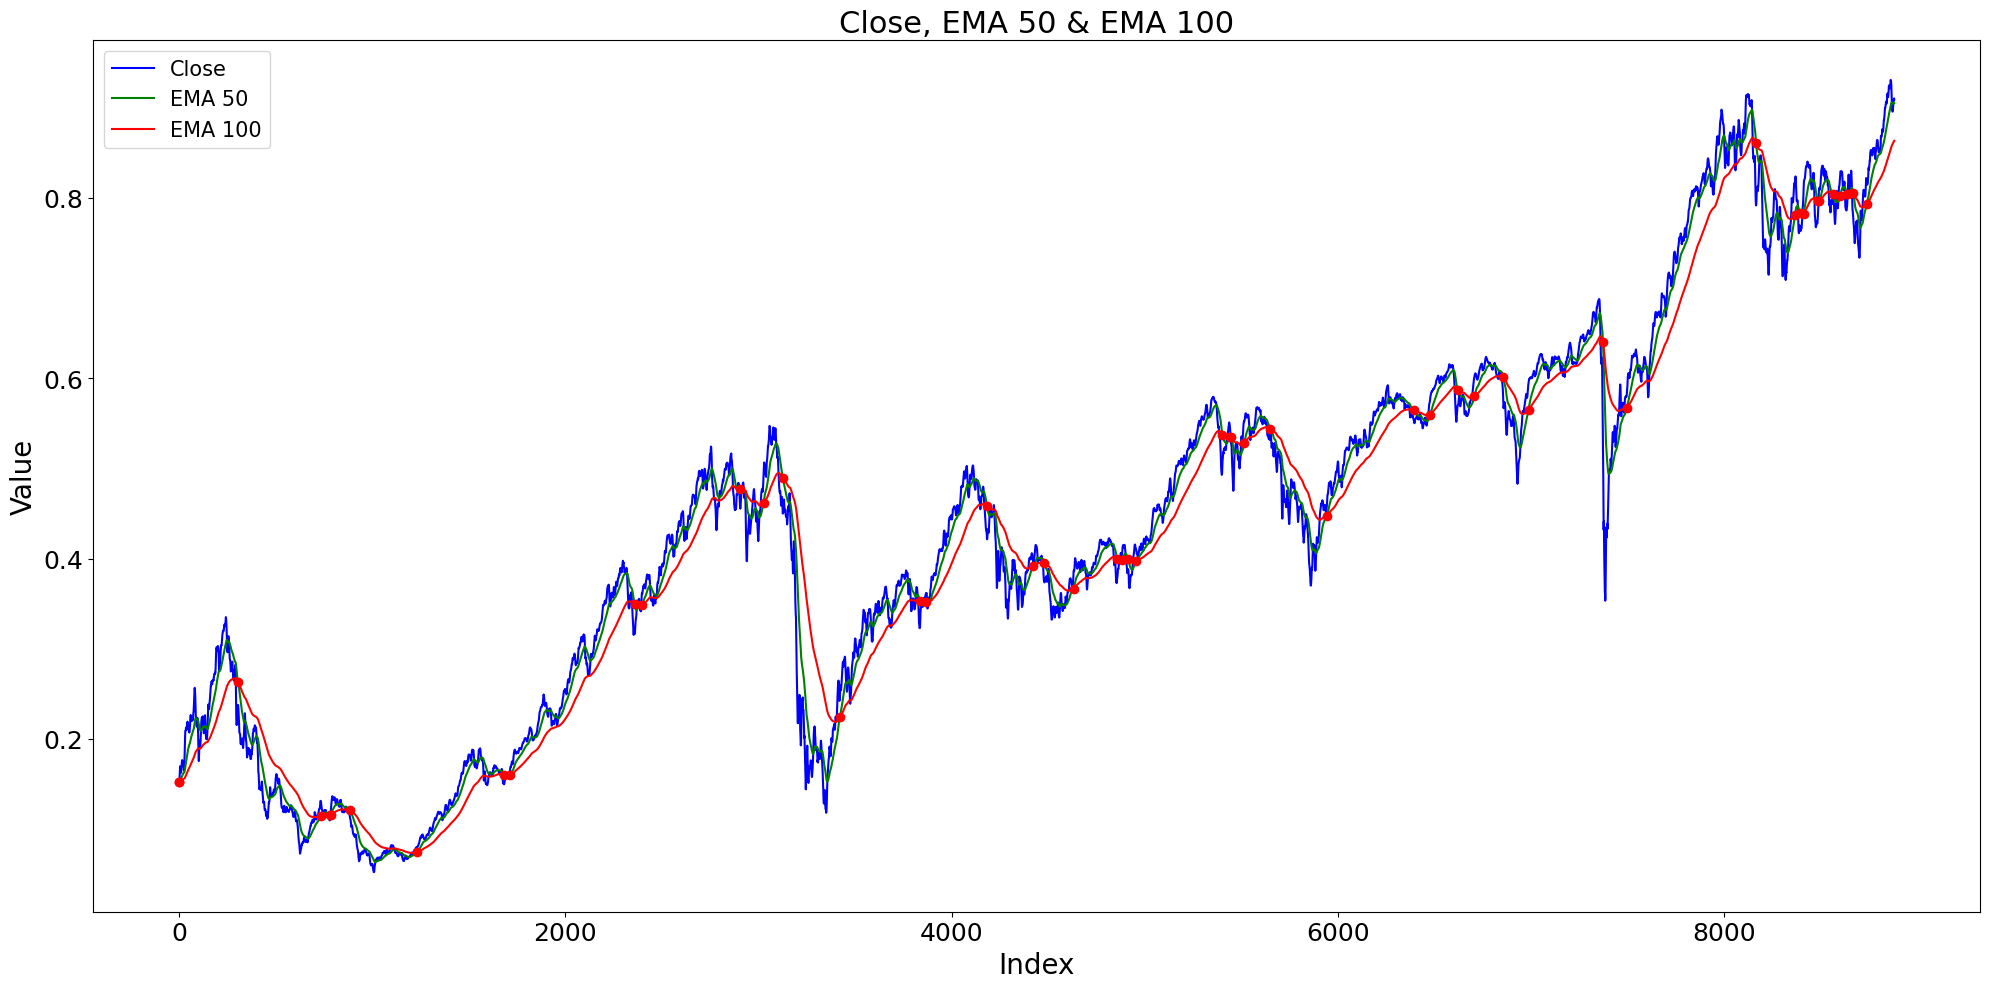

In [ ]:
fig, ax = plt.subplots(figsize = (20,10))
plt.plot(df['Close'], label='Close', color='blue')
plt.plot(df['EMA_50'], label='EMA50', color='green')
plt.plot(df['EMA_200'], label='EMA200', color='red')
plt.plot(idx1.index, df.loc[idx1.index, 'EMA_200'], 'ro', label='Sign Change')
plt.legend(['Close','EMA 50','EMA 100'], fontsize=15)
plt.title('Close, EMA 50 & EMA 100', fontsize=22)
plt.xlabel('Index', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()

## Data Buy Keep Sell


In [ ]:
df['label'] = df.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
df_buy_sell = df[df['label'] != 'Keep']
df_buy_sell

Close    EMA_50   EMA_200      Diff  sign  sign_change label
1     0.154502  0.152116  0.152043  0.000073     1            1  Sell
307   0.236372  0.262365  0.262815 -0.000450    -1            1   Buy
733   0.131159  0.114369  0.114351  0.000018     1            1  Sell
784   0.114690  0.115497  0.115511 -0.000013    -1            1   Buy
785   0.116967  0.115555  0.115525  0.000030     1            1  Sell
886   0.111915  0.120961  0.121157 -0.000195    -1            1   Buy
1230  0.079261  0.074064  0.073931  0.000133     1            1  Sell
1684  0.149911  0.159988  0.160223 -0.000235    -1            1   Buy
1714  0.166574  0.160193  0.160043  0.000150     1            1  Sell
2359  0.316257  0.348608  0.349109 -0.000500    -1            1   Buy
2398  0.360511  0.348334  0.348150  0.000184     1            1  Sell
2904  0.459829  0.476328  0.476724 -0.000396    -1            1   Buy
3027  0.500483  0.462408  0.461453  0.000955     1            1  Sell
3126  0.449836  0.489317  0.489740 -0.000423    -1            1   Buy
3422  0.251728  0.224569  0.223875  0.000694     1            1  Sell
3834  0.322784  0.352377  0.352641 -0.000264    -1            1   Buy
3866  0.360473  0.351936  0.351841  0.000095     1            1  Sell
4183  0.421258  0.457359  0.458211 -0.000852    -1            1   Buy
4423  0.395136  0.391502  0.391457  0.000045     1            1  Sell
4480  0.373536  0.394376  0.394497 -0.000121    -1            1   Buy
4631  0.384791  0.366624  0.366460  0.000164     1            1  Sell
4857  0.377765  0.399037  0.399267 -0.000230    -1            1   Buy
4882  0.404523  0.398902  0.398831  0.000070     1            1  Sell
4913  0.387914  0.399568  0.399843 -0.000274    -1            1   Buy
4952  0.411566  0.397558  0.397382  0.000176     1            1  Sell
5401  0.502032  0.537049  0.537156 -0.000107    -1            1   Buy
5439  0.548638  0.535164  0.535125  0.000039     1            1  Sell
5447  0.526947  0.534998  0.535119 -0.000121    -1            1   Buy
5515  0.552148  0.528457  0.527982  0.000475     1            1  Sell
5649  0.537423  0.544143  0.544159 -0.000015    -1            1   Buy
5942  0.458652  0.447180  0.447140  0.000040     1            1  Sell
6392  0.553426  0.563943  0.564259 -0.000316    -1            1   Buy
6478  0.579524  0.559893  0.559734  0.000159     1            1  Sell
6619  0.569590  0.586634  0.586844 -0.000210    -1            1   Buy
6706  0.602074  0.580033  0.579871  0.000162     1            1  Sell
6856  0.568994  0.600778  0.601264 -0.000486    -1            1   Buy
6986  0.594717  0.565268  0.564664  0.000604     1            1  Sell
7372  0.504550  0.636397  0.639763 -0.003366    -1            1   Buy
7496  0.584620  0.567558  0.567297  0.000262     1            1  Sell
8164  0.791740  0.860747  0.860947 -0.000200    -1            1   Buy
8366  0.817373  0.782416  0.781594  0.000822     1            1  Sell
8392  0.765576  0.782424  0.782757 -0.000333    -1            1   Buy
8411  0.815916  0.783426  0.782564  0.000863     1            1  Sell
8483  0.776791  0.796034  0.796384 -0.000350    -1            1   Buy
8491  0.811181  0.796913  0.796547  0.000366     1            1  Sell
8561  0.795561  0.804393  0.804426 -0.000033    -1            1   Buy
8600  0.827181  0.803021  0.802672  0.000349     1            1  Sell
8634  0.789968  0.804213  0.804445 -0.000232    -1            1   Buy
8641  0.820454  0.804762  0.804539  0.000223     1            1  Sell
8667  0.776880  0.805227  0.805342 -0.000114    -1            1   Buy
8737  0.817416  0.794047  0.793339  0.000708     1            1  Sell

In [ ]:
df['label1'] = df.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
df_buy_sell1 = df[df['label1'] != 0]
df_buy_sell1

Close    EMA_50   EMA_200      Diff  sign  sign_change label  label1
1     0.154502  0.152116  0.152043  0.000073     1            1  Sell      -1
307   0.236372  0.262365  0.262815 -0.000450    -1            1   Buy       1
733   0.131159  0.114369  0.114351  0.000018     1            1  Sell      -1
784   0.114690  0.115497  0.115511 -0.000013    -1            1   Buy       1
785   0.116967  0.115555  0.115525  0.000030     1            1  Sell      -1
886   0.111915  0.120961  0.121157 -0.000195    -1            1   Buy       1
1230  0.079261  0.074064  0.073931  0.000133     1            1  Sell      -1
1684  0.149911  0.159988  0.160223 -0.000235    -1            1   Buy       1
1714  0.166574  0.160193  0.160043  0.000150     1            1  Sell      -1
2359  0.316257  0.348608  0.349109 -0.000500    -1            1   Buy       1
2398  0.360511  0.348334  0.348150  0.000184     1            1  Sell      -1
2904  0.459829  0.476328  0.476724 -0.000396    -1            1   Buy       1
3027  0.500483  0.462408  0.461453  0.000955     1            1  Sell      -1
3126  0.449836  0.489317  0.489740 -0.000423    -1            1   Buy       1
3422  0.251728  0.224569  0.223875  0.000694     1            1  Sell      -1
3834  0.322784  0.352377  0.352641 -0.000264    -1            1   Buy       1
3866  0.360473  0.351936  0.351841  0.000095     1            1  Sell      -1
4183  0.421258  0.457359  0.458211 -0.000852    -1            1   Buy       1
4423  0.395136  0.391502  0.391457  0.000045     1            1  Sell      -1
4480  0.373536  0.394376  0.394497 -0.000121    -1            1   Buy       1
4631  0.384791  0.366624  0.366460  0.000164     1            1  Sell      -1
4857  0.377765  0.399037  0.399267 -0.000230    -1            1   Buy       1
4882  0.404523  0.398902  0.398831  0.000070     1            1  Sell      -1
4913  0.387914  0.399568  0.399843 -0.000274    -1            1   Buy       1
4952  0.411566  0.397558  0.397382  0.000176     1            1  Sell      -1
5401  0.502032  0.537049  0.537156 -0.000107    -1            1   Buy       1
5439  0.548638  0.535164  0.535125  0.000039     1            1  Sell      -1
5447  0.526947  0.534998  0.535119 -0.000121    -1            1   Buy       1
5515  0.552148  0.528457  0.527982  0.000475     1            1  Sell      -1
5649  0.537423  0.544143  0.544159 -0.000015    -1            1   Buy       1
5942  0.458652  0.447180  0.447140  0.000040     1            1  Sell      -1
6392  0.553426  0.563943  0.564259 -0.000316    -1            1   Buy       1
6478  0.579524  0.559893  0.559734  0.000159     1            1  Sell      -1
6619  0.569590  0.586634  0.586844 -0.000210    -1            1   Buy       1
6706  0.602074  0.580033  0.579871  0.000162     1            1  Sell      -1
6856  0.568994  0.600778  0.601264 -0.000486    -1            1   Buy       1
6986  0.594717  0.565268  0.564664  0.000604     1            1  Sell      -1
7372  0.504550  0.636397  0.639763 -0.003366    -1            1   Buy       1
7496  0.584620  0.567558  0.567297  0.000262     1            1  Sell      -1
8164  0.791740  0.860747  0.860947 -0.000200    -1            1   Buy       1
8366  0.817373  0.782416  0.781594  0.000822     1            1  Sell      -1
8392  0.765576  0.782424  0.782757 -0.000333    -1            1   Buy       1
8411  0.815916  0.783426  0.782564  0.000863     1            1  Sell      -1
8483  0.776791  0.796034  0.796384 -0.000350    -1            1   Buy       1
8491  0.811181  0.796913  0.796547  0.000366     1            1  Sell      -1
8561  0.795561  0.804393  0.804426 -0.000033    -1            1   Buy       1
8600  0.827181  0.803021  0.802672  0.000349     1            1  Sell      -1
8634  0.789968  0.804213  0.804445 -0.000232    -1            1   Buy       1
8641  0.820454  0.804762  0.804539  0.000223     1            1  Sell      -1
8667  0.776880  0.805227  0.805342 -0.000114    -1            1   Buy       1
8737  0.817416  0.794047  0.793

In [ ]:
datacnn = df.copy()
datacnn = df[['Close','label1']]
datacnn

Close  label1
0     0.152018       0
1     0.154502      -1
2     0.152018       0
3     0.154502       0
4     0.160555       0
...        ...     ...
8875  0.906419       0
8876  0.907809       0
8877  0.909195       0
8878  0.910525       0
8879  0.909367       0

[8880 rows x 2 columns]

In [ ]:
def windowed_df_close(data, n):
    dates = []
    data_as_np = data.to_numpy()
    l = data.shape[0]
    dates = []
    X, Y = [], []
    for i in range(n, l):
        indexes = data.index[i-n:i+1]
        row = [r for r in data_as_np[i-n:i]]
        X.append(row)
        y = data_as_np[i][0]
        Y.append(y)
        dates.append(indexes[-1])
    return np.array(X), np.array(Y), np.array(dates)

X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mq_80 = int(n_total2*0.8)
Mq_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mq_80], X_pred[:Mq_80], y_pred[:Mq_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mq_80:Mq_90],  X_pred[Mq_80:Mq_90], y_pred[Mq_80:Mq_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mq_90:],  X_pred[Mq_90:], y_pred[Mq_90:]

In [ ]:
datacnn

Close  label1
0     0.152018       0
1     0.154502      -1
2     0.152018       0
3     0.154502       0
4     0.160555       0
...        ...     ...
8875  0.906419       0
8876  0.907809       0
8877  0.909195       0
8878  0.910525       0
8879  0.909367       0

[8880 rows x 2 columns]

In [ ]:
X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape

((7102, 2, 2), (888, 2, 2), (888, 2, 2), (888,))

In [ ]:
datafull2 = data_full.copy()
datafull2.index = datafull2['Date']
datafull2 = data_full['Close']
datafull2 = datafull2[3:]
datafull2 = datafull2.rename(columns={'^GSPTSE': 'Close'})

datafull2['EMA_50'] = datafull2['Close'].ewm(span=50, adjust=False).mean()
datafull2['EMA_200']= datafull2['Close'].ewm(span=200, adjust=False).mean()
datafull2['Diff'] = datafull2['EMA_50']-datafull2['EMA_200']
datafull2['sign'] = datafull2['Diff'].apply(lambda x:1 if x>0 else (-1 if x<0 else 0))
datafull2['sign_change'] = datafull2['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
idx1 = datafull2[datafull2['sign_change']==1]
datafull2['label'] = datafull2.apply(
    lambda row: 'Buy' if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                ('Sell' if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 'Keep'),
    axis=1
)
datafull2_buy_sell = datafull2[datafull2['label'] != 'Keep']
datafull2['label1'] = datafull2.apply(
    lambda row: 1 if row['sign_change'] == 1 and row['EMA_50'] < row['EMA_200'] else
                (-1 if row['sign_change'] == 1 and row['EMA_50'] > row['EMA_200'] else 0),
    axis=1
)
datafull2_buy_sell1 = datafull2[datafull2['label1'] != 0]

datafull2 = datafull2[['Close', 'label1']]
datafull2['Close'] = pd.to_numeric(datafull2['Close'])
datafull2['label1'] = pd.to_numeric(datafull2['label1'])

X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
datafull2

Ticker         Close  label1
Date                        
2000-01-07  0.164048       0
2000-01-08  0.167510      -1
2000-01-09  0.170972       0
2000-01-10  0.174434       0
2000-01-11  0.164840       0
...              ...     ...
2024-04-25  0.971416       0
2024-04-26  0.976444       0
2024-04-27  0.977292       0
2024-04-28  0.978140       0
2024-04-29  0.978988       0

[8880 rows x 2 columns]

## CNN HYPERPARAMETER TUNING

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 9.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_cnn_model(hp):
    model = Sequential()

    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same",
        input_shape=(2, 2)
    ))

    model.add(Flatten())

    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_cnn',
    project_name='cnn_tuning_activation'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Menampilkan hasil terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Filters: {best_hps.get('filters')}
- Activation (Conv1D): {best_hps.get('activation_conv')}
- Dense Layer Units: {best_hps.get('dense_units')}
- Activation (Dense): {best_hps.get('activation_dense')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 32s]
val_loss: 0.0006808016914874315

Best val_loss So Far: 0.00030385164427571
Total elapsed time: 00h 48m 44s

Best Hyperparameters:
- Filters: 16
- Activation (Conv1D): relu
- Dense Layer Units: 64
- Activation (Dense): tanh
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp

def build_cnn_model(hp):
    model = Sequential()
    model.add(Reshape((2, 2), input_shape=(2, 2)))
    model.add(Conv1D(
        filters=hp.Choice('filters', values=[8, 16, 32, 64]),
        kernel_size=2,
        activation=hp.Choice('activation_conv', values=['relu', 'tanh']),
        padding="same"
    ))
    model.add(Flatten())
    model.add(Dense(
        units=hp.Choice('dense_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_dense', values=['relu', 'tanh'])
    ))
    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))
    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model


bayesian_opt_tuner = BayesianOptimization(
    build_cnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='bayesian cnn',
    project_name='kerastuner_bayesian_cnn',
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Trial 60 Complete [00h 00m 31s]
val_loss: 0.0003771928313653916

Best val_loss So Far: 0.0003164371591992676
Total elapsed time: 00h 41m 00s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("Best Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

best_cnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_cnn_models[0]

Best Hyperparameters:
filters: 8
activation_conv: relu
dense_units: 128
activation_dense: relu
dropout: 0.1
learning_rate: 0.001


## CNN MODEL

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datacnn, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(16, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(64, activation="tanh"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 2, 16)          │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257 (8.82 KB)

 Trainable params: 2,257 (8.82 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnrs_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-3 dengan MAPE = 0.0173


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.960513   0.947670   0.963866   0.953069   0.914663   0.963489   
2021-11-25   0.957098   0.944362   0.960326   0.949692   0.911658   0.959981   
2021-11-26   0.955242   0.942256   0.959024   0.947872   0.909765   0.958344   
2021-11-27   0.954986   0.941768   0.959239   0.947629   0.909336   0.958288   
2021-11-28   0.954314   0.941218   0.958342   0.946960   0.908830   0.957512   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.980014   0.965815   0.985571   0.972380   0.931203   0.984175   
2024-04-26   0.982125   0.968177   0.987126   0.974452   0.933331   0.986071   
2024-04-27   0.983745   0.969813   0.988672   0.976050   0.934815   0.987678   
2024-04-28   0.985323   0.971367   0.990257   0.977609   0.936227   0.989279   
2024-04-29   0.986845   0.972875   0.991769   0.979112   0.937597   0.990816   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnrs_val_INDO.csv')


In [ ]:
!zip -r cnnrs_weights.zip /content/cnnrs_weights
from google.colab import files
files.download("cnnrs_weights.zip")

  adding: content/cnnrs_weights/ (stored 0%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 51%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 50%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 50%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 52%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 51%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 50%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 50%)
  adding: content/cnnrs_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 51%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

146.76275123274633 41711.71286764065 204.2344556328355 289287032370839.56
204.85732326564843 104261.37853213363 322.89530583787314 0.019307980400846577
252.8733634513419 105315.40311138566 324.523347559749 0.01747190728497531


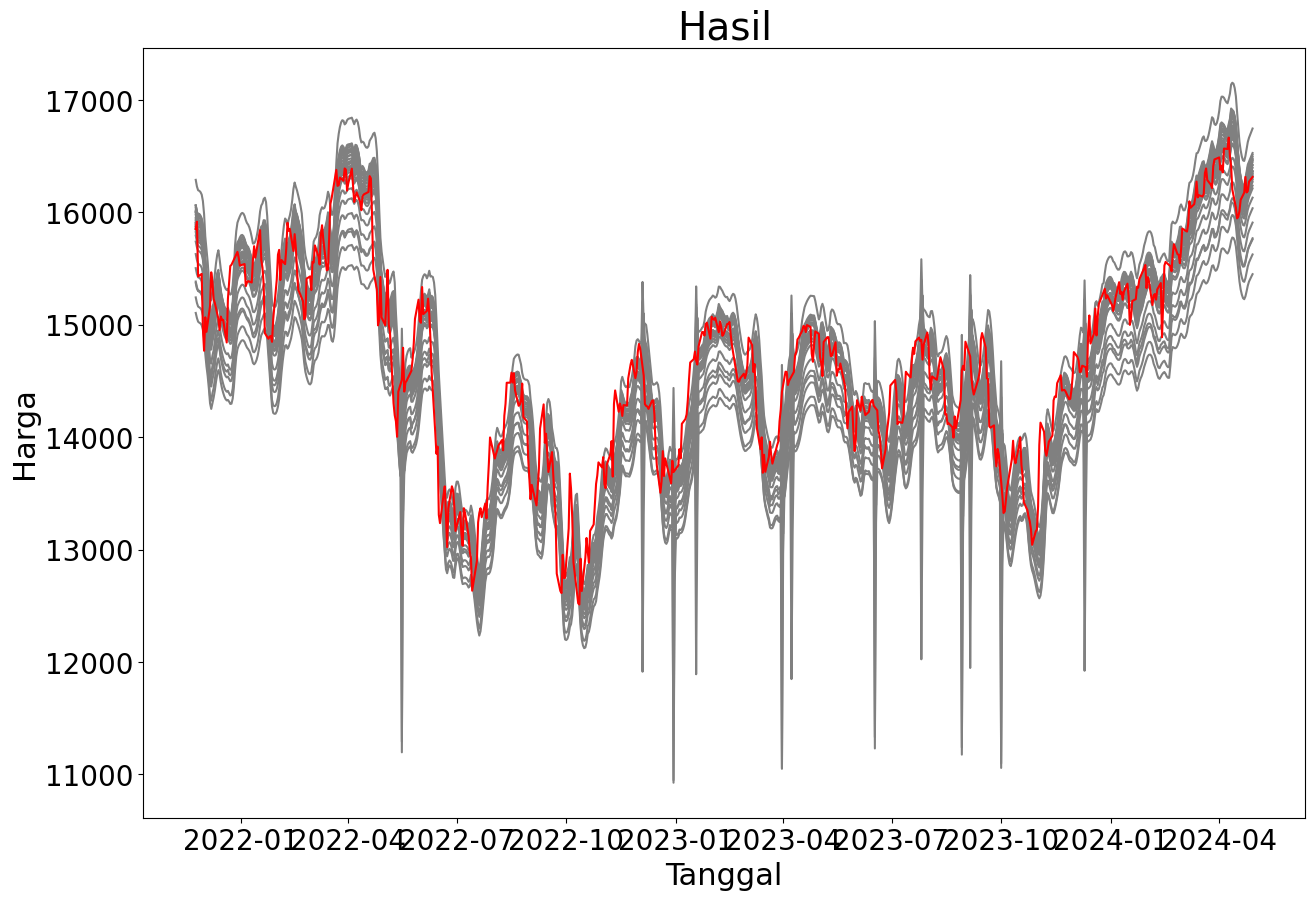

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

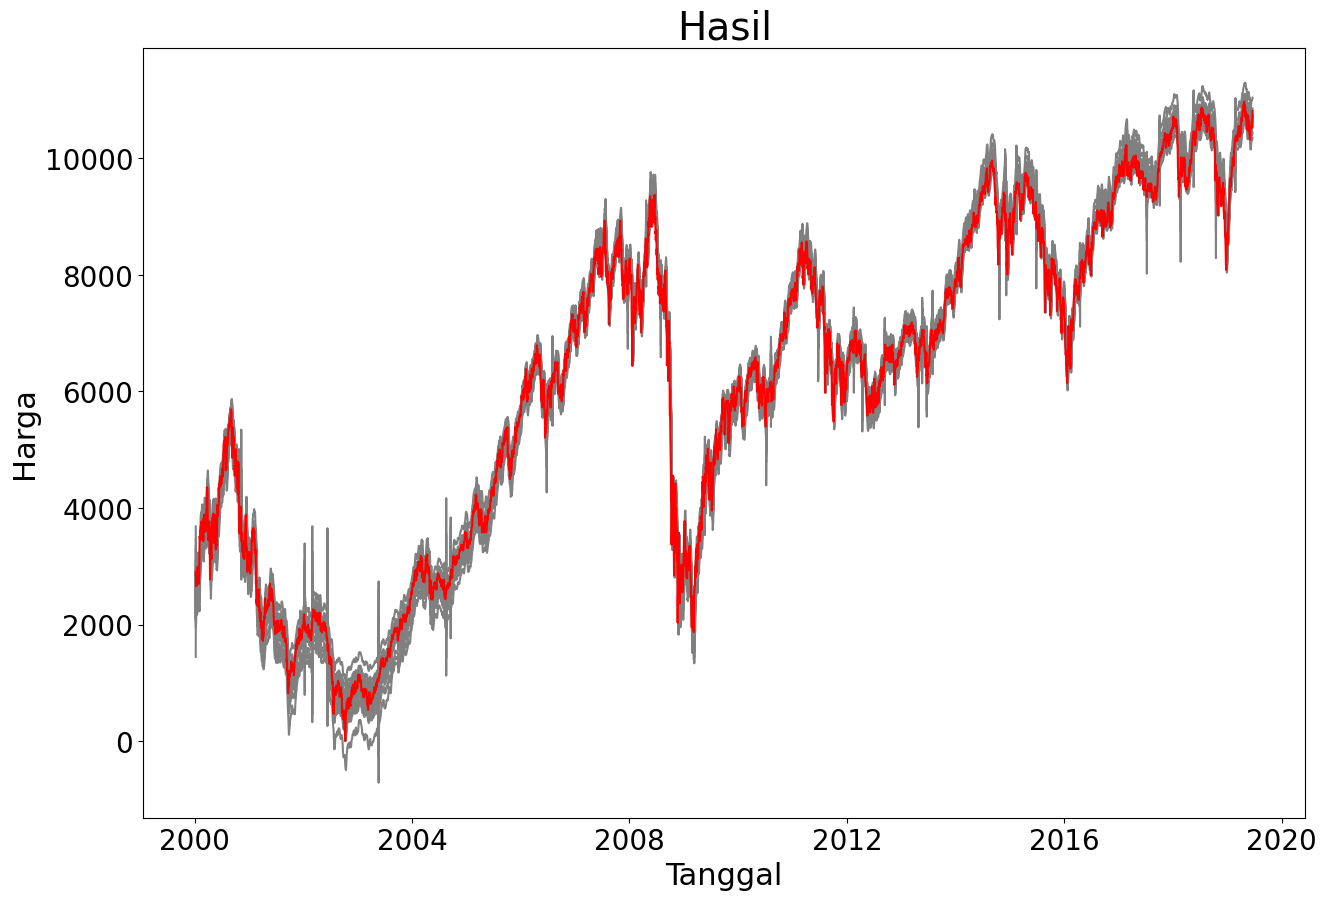

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## CNN dengan Bayesian

In [ ]:
X_pred, y_pred, dates_pred = windowed_df_close(datacnn, 2)
n_total2 = len(X_pred)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_pred_train, X_pred_train, y_pred_train = dates_pred[:Mqn_80], X_pred[:Mqn_80], y_pred[:Mqn_80]
dates_pred_val, X_pred_val, y_pred_val = dates_pred[Mqn_80:Mqn_90],  X_pred[Mqn_80:Mqn_90], y_pred[Mqn_80:Mqn_90]
dates_pred_test, X_pred_test, y_pred_test = dates_pred[Mqn_90:],  X_pred[Mqn_90:], y_pred[Mqn_90:]
print(X_pred_train.shape, X_pred_val.shape, X_pred_test.shape, y_pred_test.shape)
print(y_pred_train.shape, y_pred_val.shape, y_pred_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
cnn = Sequential()
cnn.add(Reshape((2, 2), input_shape=(2, 2)))
cnn.add(Conv1D(8, kernel_size=2, activation="relu", padding="same"))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.1))
cnn.add(Dense(1, activation="linear"))

cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

cnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 2, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 8)           │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,345 (9.16 KB)

 Trainable params: 2,345 (9.16 KB)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("cnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(cnn)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"cnnbo_weights/best_cnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-24 dengan MAPE = 0.0160


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.951531   0.905953   0.948116   0.960912   0.953455   0.953462   
2021-11-25   0.948143   0.903308   0.944714   0.957372   0.949855   0.949973   
2021-11-26   0.946392   0.902252   0.942886   0.955660   0.949138   0.948675   
2021-11-27   0.946207   0.902348   0.942647   0.955558   0.949828   0.948876   
2021-11-28   0.945512   0.901706   0.941971   0.954794   0.948720   0.947997   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.971123   0.922004   0.967618   0.981664   0.977056   0.974865   
2024-04-26   0.973132   0.923255   0.969707   0.983643   0.978021   0.976418   
2024-04-27   0.974725   0.924433   0.971321   0.985283   0.979471   0.977952   
2024-04-28   0.976289   0.925629   0.972897   0.986907   0.981043   0.979522   
2024-04-29   0.977796   0.926773   0.974417   0.988469   0.982525   0.981021   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')


In [ ]:
!zip -r cnnbo_weights.zip /content/cnnbo_weights
from google.colab import files
files.download("cnnbo_weights.zip")

  adding: content/cnnbo_weights/ (stored 0%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_16.weights.h5 (deflated 49%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_2.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_18.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_27.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_13.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_22.weights.h5 (deflated 49%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_26.weights.h5 (deflated 49%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_12.weights.h5 (deflated 51%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_19.weights.h5 (deflated 50%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_30.weights.h5 (deflated 51%)
  adding: content/cnnbo_weights/best_cnnrs_weights_iter_28.weights.h5 (deflated 50%)
  adding: content/cnn

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

139.91892575094158 39620.31179131112 199.0485161746028 326231579060213.06
212.80946510475317 106477.20833594447 326.30845581434824 0.019777936003957473
277.03344469958233 116832.3948627978 341.8075406757402 0.01905285900281789


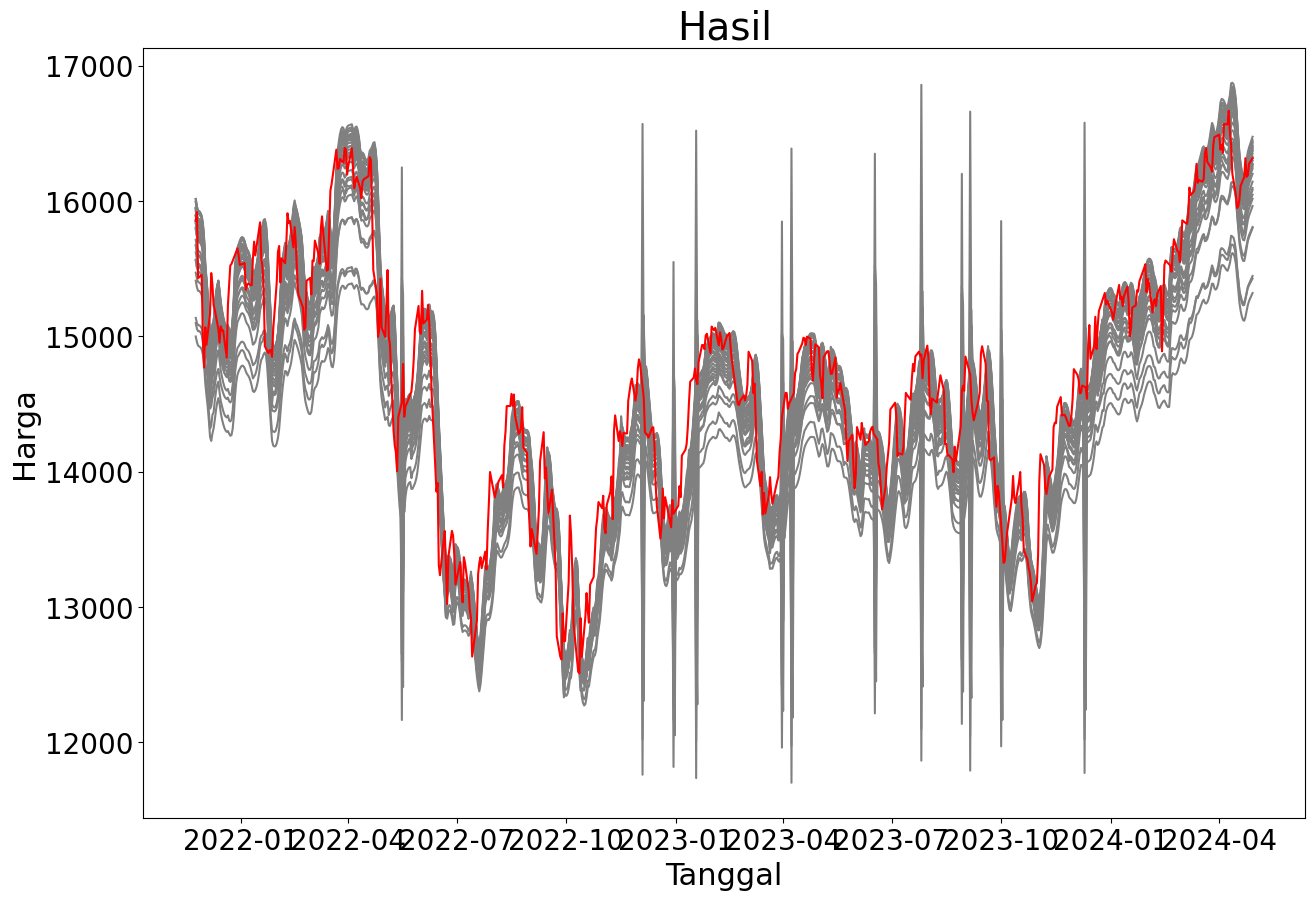

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

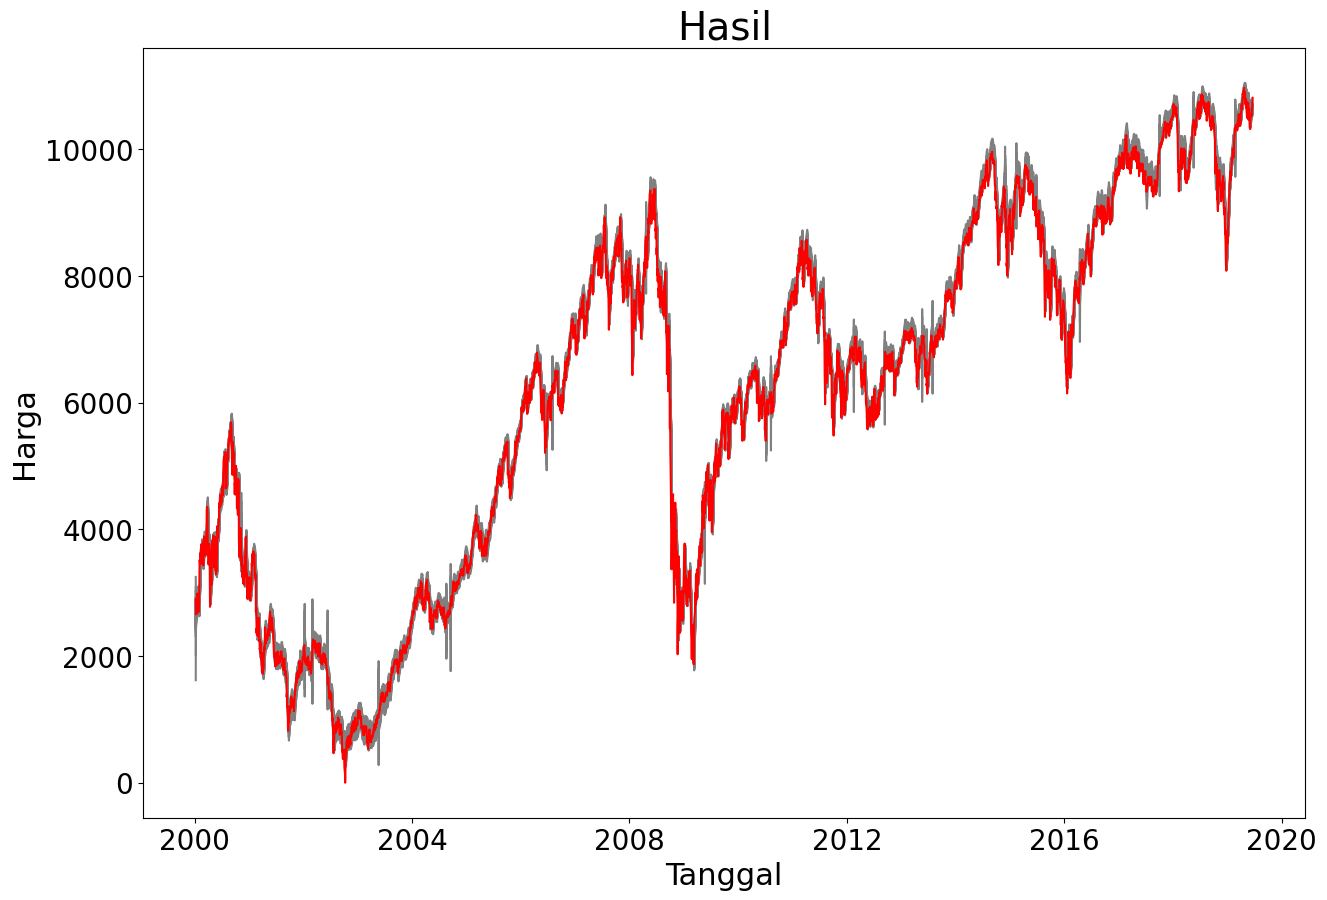

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape

def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2,2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_ann',
    project_name='ann_tuning'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- Dense Layer 1 Units: {best_hps.get('dense_units_1')}
- Activation 1: {best_hps.get('activation_1')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 00m 42s]
val_loss: 0.00040723735583014786

Best val_loss So Far: 0.0003789538750424981
Total elapsed time: 00h 47m 02s

Best Hyperparameters:
- Dense Layer 1 Units: 32
- Activation 1: sigmoid
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters as hp
def build_ann_model(hp):
    model = Sequential()
    model.add(Flatten(input_shape=(2, 2)))

    model.add(Dense(
        units=hp.Choice('dense_units_1', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation_1', values=['relu', 'tanh', 'sigmoid'])
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1, activation="linear"))

    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])
        ),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_ann_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

best_ann_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_ann_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 50s]
val_loss: 0.0015279834624379873

Best val_loss So Far: 0.00036339423968456686
Total elapsed time: 00h 47m 38s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
dense_units_1: 32
activation_1: sigmoid
dropout: 0.2
learning_rate: 0.01


In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(32, activation='sigmoid'))
ann.add(Dropout(0.1))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annrs_weights/best_annrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-29 dengan MAPE = 0.0167


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.943682   0.950609   0.948580   0.970903   0.943613   0.955695   
2021-11-25   0.941286   0.947999   0.945943   0.968230   0.941301   0.953252   
2021-11-26   0.939440   0.945951   0.943911   0.966175   0.939494   0.951361   
2021-11-27   0.938842   0.945270   0.943251   0.965511   0.938898   0.950745   
2021-11-28   0.938537   0.944952   0.942918   0.965170   0.938611   0.950437   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.955728   0.963658   0.961881   0.984318   0.955140   0.967937   
2024-04-26   0.957634   0.965780   0.964002   0.986431   0.956988   0.969882   
2024-04-27   0.958804   0.967067   0.965302   0.987729   0.958112   0.971073   
2024-04-28   0.959874   0.968241   0.966493   0.988917   0.959137   0.972161   
2024-04-29   0.960916   0.969385   0.967654   0.990073   0.960135   0.973220   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksiannrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksiannrs_val_INDO.csv')


In [ ]:
!zip -r annrs_weights.zip /content/annrs_weights
from google.colab import files
files.download("annrs_weights.zip")

  adding: content/annrs_weights/ (stored 0%)
  adding: content/annrs_weights/best_annrs_weights_iter_1.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_16.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_3.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_29.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_11.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_12.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_26.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_28.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_27.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_7.weights.h5 (deflated 86%)
  adding: content/annrs_weights/best_annrs_weights_iter_23.weights.h5 (deflated 86%)
  adding: content/annrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

167.086292431494 54075.06910918318 232.54046768075267 336449435674885.25
193.42104598494967 102580.82739821907 320.2824181846688 0.018809144670709353
244.06525109093477 106951.80300264517 327.0348651178421 0.01699613918281837


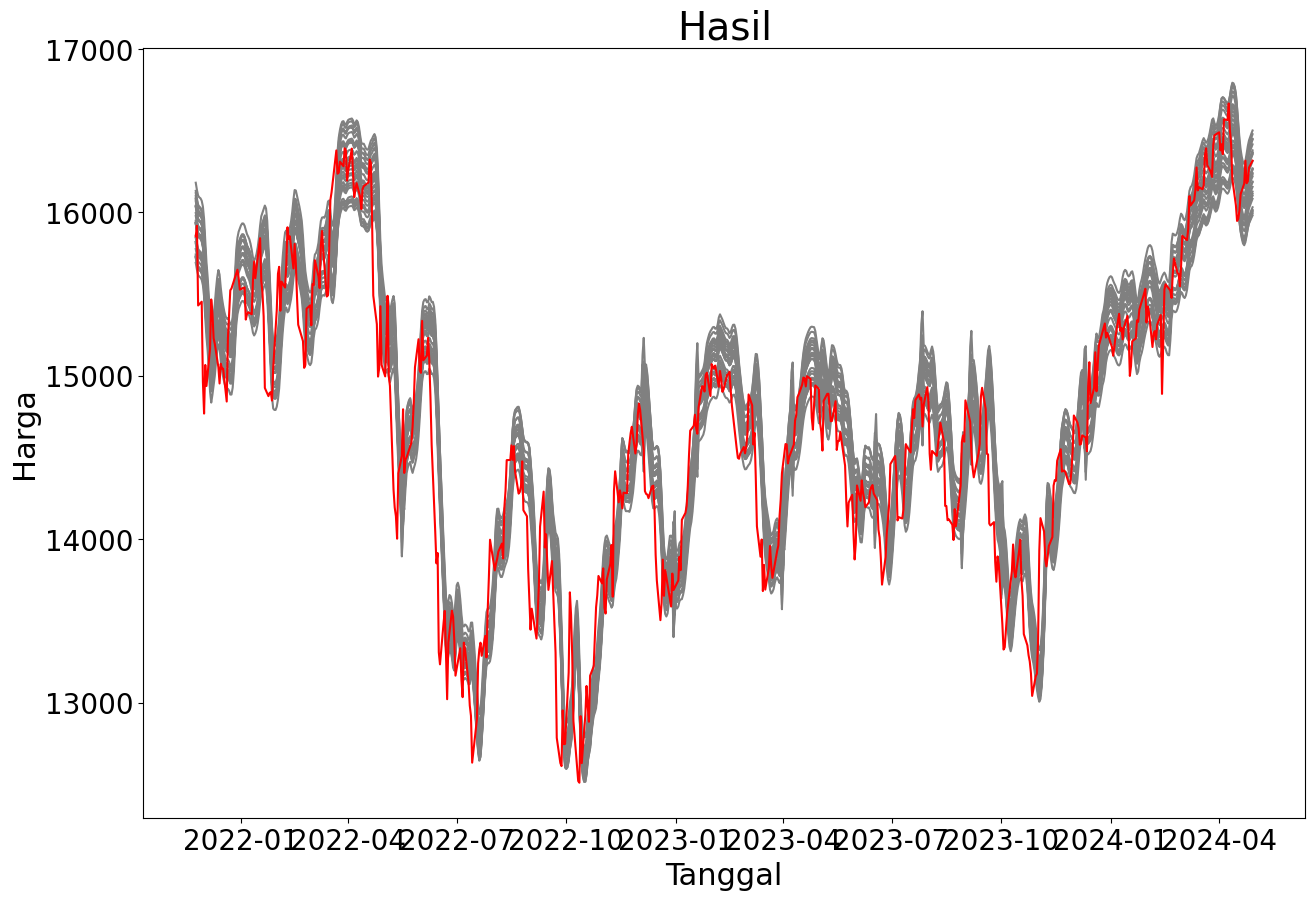

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

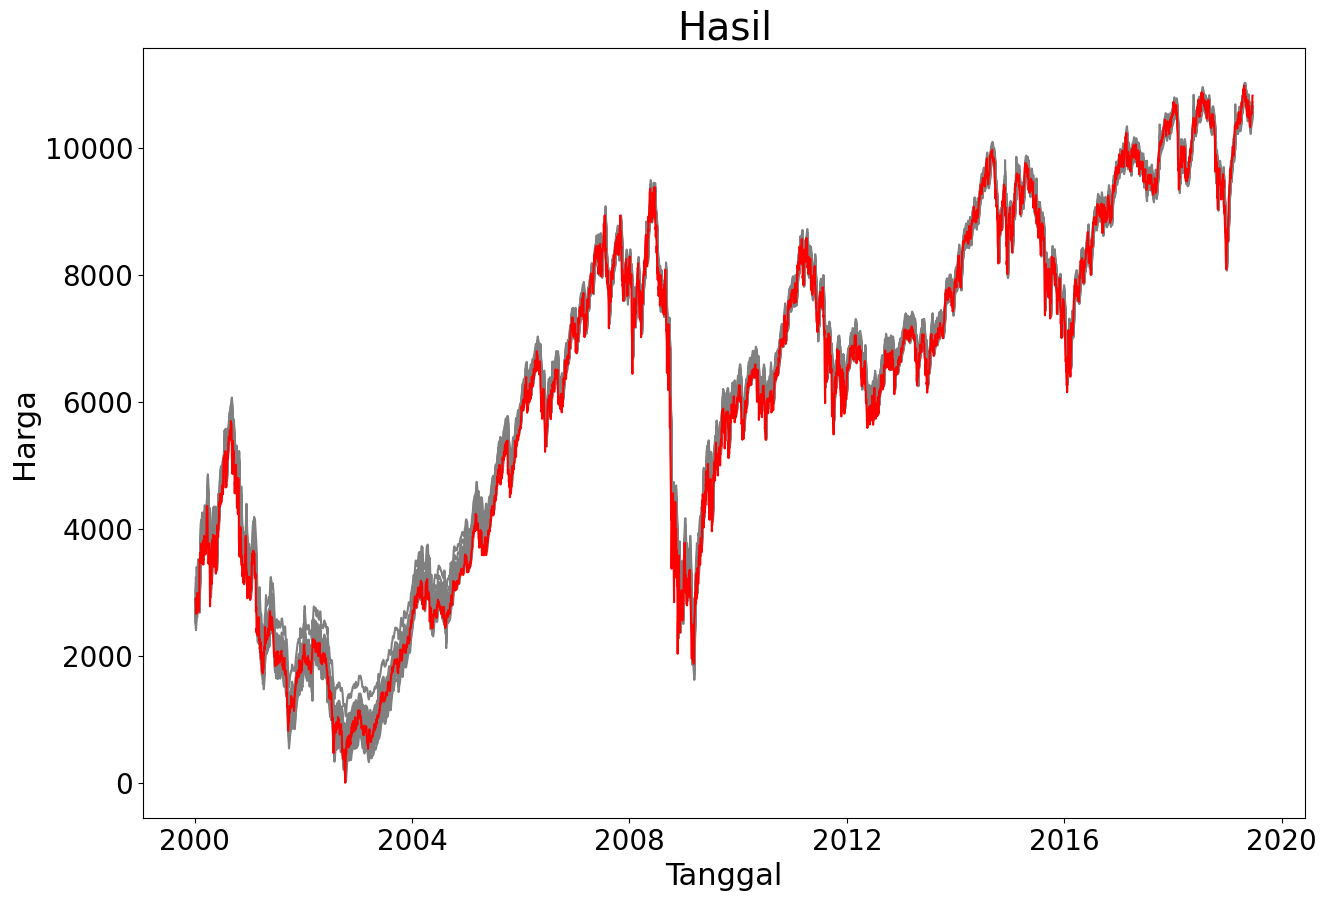

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## ANN dengan Bayesian

In [ ]:
ann = Sequential()
ann.add(Flatten(input_shape=(2,2)))
ann.add(Dense(32, activation='sigmoid'))
ann.add(Dropout(0.2))
ann.add(Dense(1, activation='linear'))

ann.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

ann.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("annbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(ann)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"annbo_weights/best_annbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-27 dengan MAPE = 0.0170


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.937449   0.934749   0.969118   0.936773   0.955885   0.954892   
2021-11-25   0.935545   0.932607   0.966439   0.934554   0.953589   0.952742   
2021-11-26   0.934084   0.930956   0.964379   0.932834   0.951804   0.951089   
2021-11-27   0.933616   0.930421   0.963714   0.932272   0.951219   0.950556   
2021-11-28   0.933367   0.930147   0.963372   0.931992   0.950929   0.950278   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.946848   0.945430   0.982588   0.947836   0.967279   0.965563   
2024-04-26   0.948287   0.947103   0.984714   0.949587   0.969078   0.967214   
2024-04-27   0.949171   0.948129   0.986020   0.950657   0.970175   0.968228   
2024-04-28   0.949979   0.949067   0.987216   0.951634   0.971176   0.969155   
2024-04-29   0.950763   0.949978   0.988380   0.952585   0.972149   0.970054   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksiannbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksiannbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksiannbo_val_INDO.csv')


In [ ]:
!zip -r annbo_weights.zip /content/annbo_weights
from google.colab import files
files.download("annbo_weights.zip")

  adding: content/annbo_weights/ (stored 0%)
  adding: content/annbo_weights/best_annbo_weights_iter_20.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_29.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_8.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_17.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_19.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_5.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_24.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_27.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_14.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_18.weights.h5 (deflated 86%)
  adding: content/annbo_weights/best_annbo_weights_iter_22.weights.h5 (deflated 86%)
  adding: content/annb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

205.3959333277461 76479.2901353927 276.5488928478881 331182245503075.2
198.1065065309449 102663.24754718858 320.411060275997 0.019216140491154
244.008604234117 102184.36445836387 319.6628919007708 0.016916782912246252


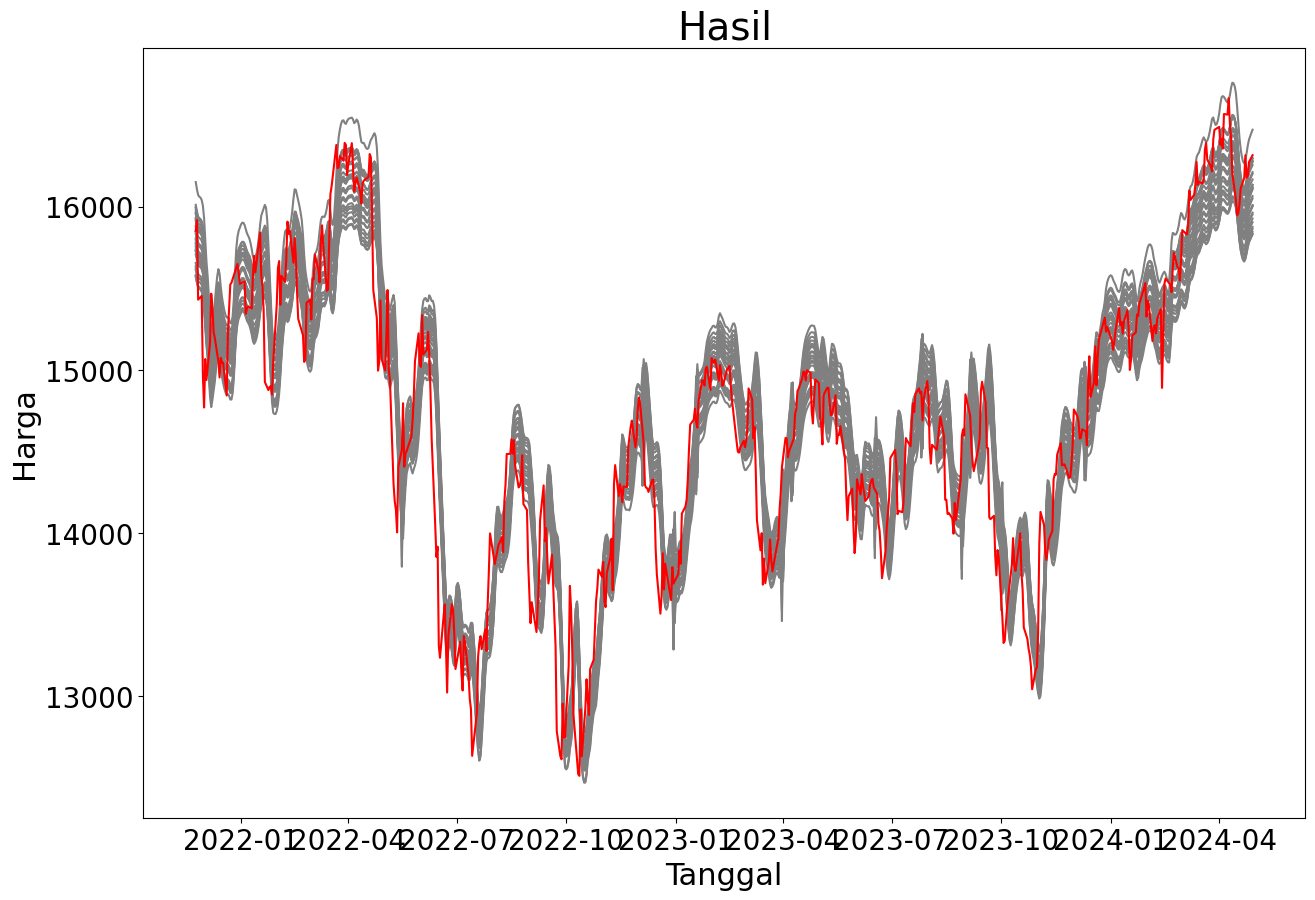

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

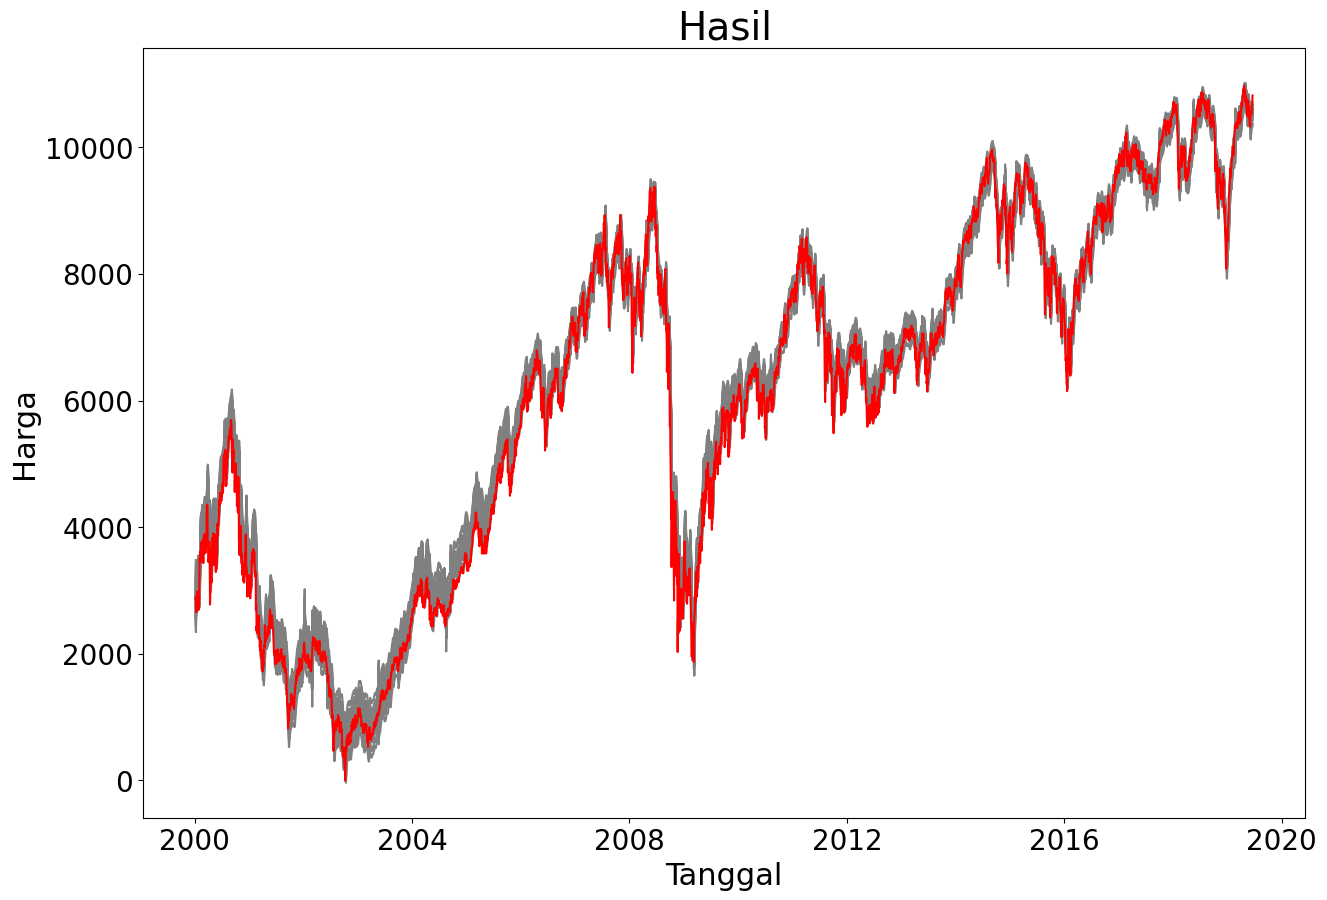

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN

In [ ]:
import keras_tuner as kt
from tensorflow.keras.layers import SimpleRNN
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    directory='random_search_rnn',
    project_name='rnn_tuning'
)

tuner.search(
    X_pred_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best Hyperparameters:
- RNN Units: {best_hps.get('rnn_units')}
- Activation: {best_hps.get('activation')}
- Dropout: {best_hps.get('dropout')}
- Learning Rate: {best_hps.get('learning_rate')}
""")

Trial 60 Complete [00h 01m 06s]
val_loss: 0.0003528223023749888

Best val_loss So Far: 0.0003528223023749888
Total elapsed time: 01h 00m 04s

Best Hyperparameters:
- RNN Units: 8
- Activation: tanh
- Dropout: 0.1
- Learning Rate: 0.01



In [ ]:
def build_rnn_model(hp):
    model = Sequential()
    model.add(SimpleRNN(
        units=hp.Choice('rnn_units', values=[8, 16, 32, 64, 128]),
        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
        input_shape=(2, 2),
        return_sequences=False
    ))

    model.add(Dropout(rate=hp.Choice('dropout', values=[0.1, 0.2, 0.3])))

    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
        loss='mse',
        metrics=['mean_absolute_error']
    )

    return model

bayesian_opt_tuner = kt.BayesianOptimization(
    build_rnn_model,
    objective='val_loss',
    max_trials=60,
    executions_per_trial=1,
    overwrite=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta=0.0001,
    restore_best_weights=True
)

bayesian_opt_tuner.search(
    X_pred_train, y_train,
    epochs=150,
    validation_data=(X_pred_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)
best_rnn_models = bayesian_opt_tuner.get_best_models(num_models=1)
model = best_rnn_models[0]

print("\n--- Best Model Summary ---")
model.summary()

best_trial = bayesian_opt_tuner.oracle.get_best_trials(num_trials=1)[0]
best_hyperparameters = best_trial.hyperparameters.values
print("\nBest Hyperparameters:")
for param, value in best_hyperparameters.items():
    print(f"{param}: {value}")

Trial 60 Complete [00h 00m 32s]
val_loss: 0.00046340926201082766

Best val_loss So Far: 0.00037534357397817075
Total elapsed time: 00h 55m 04s

--- Best Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
rnn_units: 8
activation: sigmoid
dropout: 0.1
learning_rate: 0.01


In [ ]:
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import Conv1D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
rnn = Sequential()
rnn.add(SimpleRNN(8, activation='tanh', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnrs_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnrs_weights/best_rnnrs_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-22 dengan MAPE = 0.0166


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.926123   0.903004   0.910707   0.946791   0.929456   0.924340   
2021-11-25   0.923251   0.900352   0.907972   0.943109   0.926631   0.921548   
2021-11-26   0.921751   0.898642   0.906108   0.942286   0.924885   0.919530   
2021-11-27   0.921582   0.898233   0.905609   0.942922   0.924509   0.918931   
2021-11-28   0.920996   0.897798   0.905193   0.941819   0.924021   0.918544   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.942633   0.917452   0.925389   0.970692   0.945038   0.939047   
2024-04-26   0.944332   0.919350   0.927453   0.971794   0.946982   0.941272   
2024-04-27   0.945671   0.920654   0.928823   0.973305   0.948356   0.942695   
2024-04-28   0.946984   0.921890   0.930110   0.974925   0.949667   0.944017   
2024-04-29   0.948249   0.923090   0.931362   0.976457   0.950938   0.945307   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnrs_INDO.csv')
bm_train_predictions.to_csv('hasilprediksirnnrs_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksirnnrs_val_INDO.csv')


In [ ]:
!zip -r rnnrs_weights.zip /content/rnnrs_weights
from google.colab import files
files.download("rnnrs_weights.zip")

  adding: content/rnnrs_weights/ (stored 0%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_20.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_29.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_12.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_16.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_3.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_9.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_10.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_17.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_25.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_1.weights.h5 (deflated 89%)
  adding: content/rnnrs_weights/best_rnnrs_weights_iter_23.weights.h5 (deflated 89%)
  adding: content/rnnrs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

186.92548293515935 60666.02723613766 246.304744648043 438790985610137.6
286.0164582306916 164562.36407678042 405.6628699755259 0.025183514081735702
450.9077331726256 258394.24318716393 508.3249385847245 0.03054969412938876


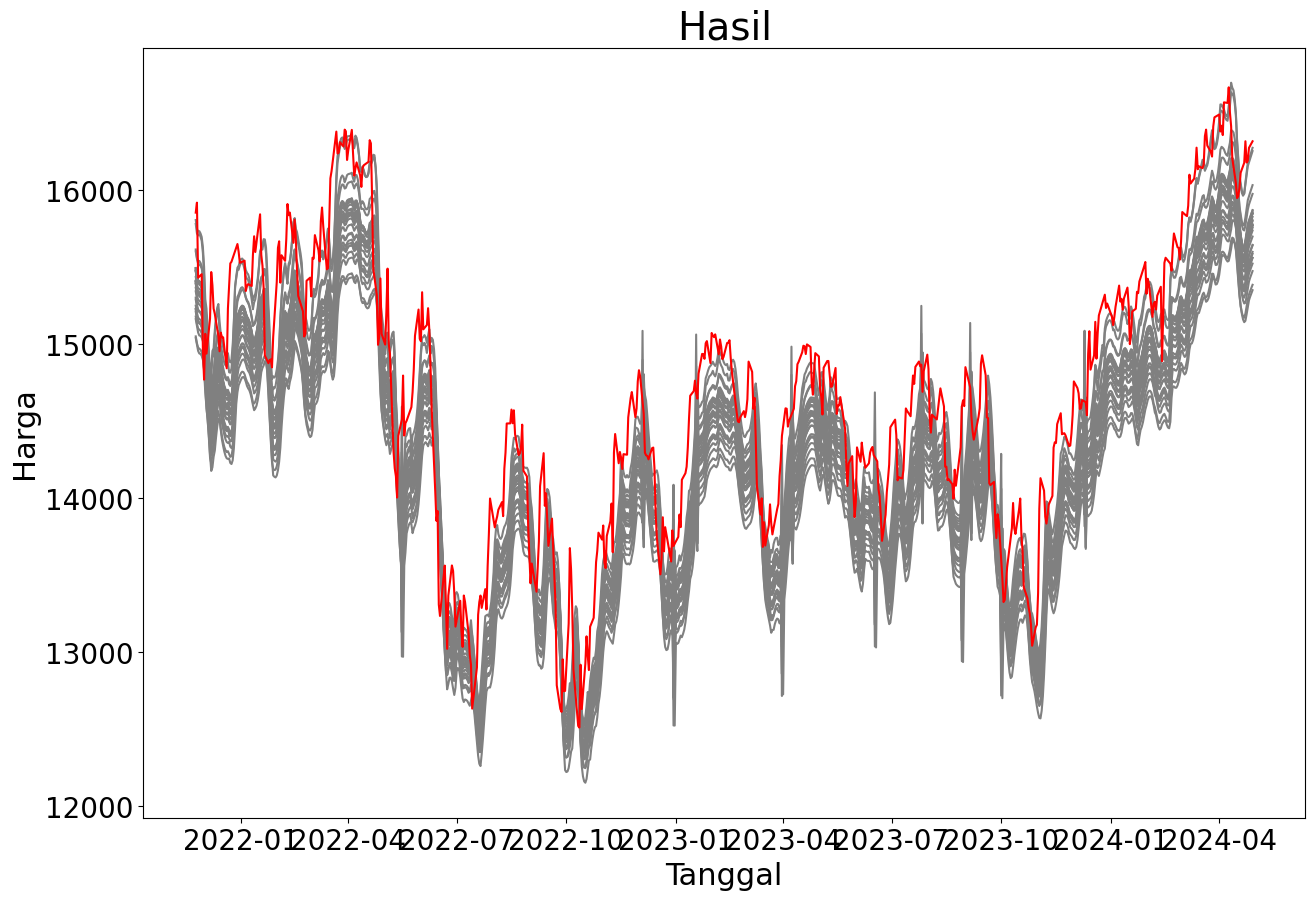

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

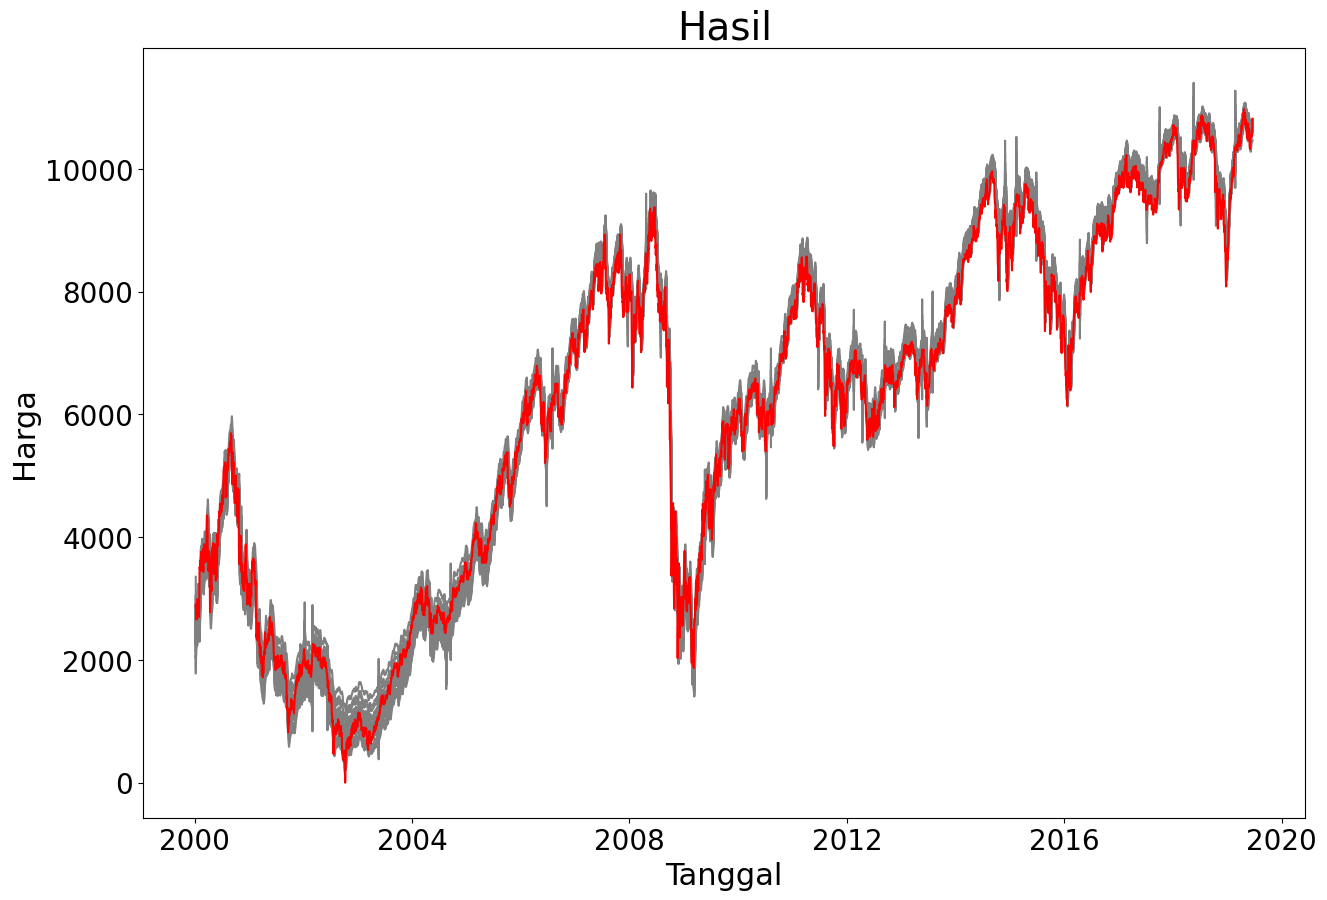

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## RNN dengan Bayesian

In [ ]:
from tensorflow.keras.layers import SimpleRNN
rnn = Sequential()
rnn.add(SimpleRNN(8, activation='sigmoid', input_shape=(2, 2), return_sequences=False))
rnn.add(Dropout(0.1))
rnn.add(Dense(1))

rnn.compile(
    optimizer=Adam(learning_rate=0.01),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

rnn.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97 (388.00 B)

 Trainable params: 97 (388.00 B)

 Non-trainable params: 0 (0.00 B)

## Best Model MAPE

In [ ]:
X_real, y_real, dates_real = windowed_df_close(datafull2, 2)
n_total2 = len(X_real)
Mqn_80 = int(n_total2*0.8)
Mqn_90 = int(n_total2*0.9)
dates_train, X_train, y_train = dates_real[:Mqn_80], X_real[:Mqn_80], y_real[:Mqn_80]
dates_val, X_val, y_val = dates_real[Mqn_80:Mqn_90],  X_real[Mqn_80:Mqn_90], y_real[Mqn_80:Mqn_90]
dates_test, X_test, y_test = dates_real[Mqn_90:],  X_real[Mqn_90:], y_real[Mqn_90:]
print(X_train.shape, X_val.shape, X_test.shape, y_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(7102, 2, 2) (888, 2, 2) (888, 2, 2) (888,)
(7102,) (888,) (888,)


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta = 0.0001,
    patience=20,
    restore_best_weights=True
)

In [ ]:
bm_result = []
bm_mapes = []
bm_prediction_result = []
bm_histories = []
bm_train_predictions = []
bm_val_predictions = []
bm_train_mapes = []
bm_val_mapes = []

import os
os.makedirs("rnnbo_weights", exist_ok=True)

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(rnn)
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mean_absolute_error'])

    checkpoint_path = f"rnnbo_weights/best_rnnbo_weights_iter_{i+1}.weights.h5"
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        mode='min',
        verbose=0
    )

    history = model.fit(
        X_pred_train, y_train,
        batch_size=32,
        validation_data=(X_pred_val, y_val),
        epochs=150,
        callbacks=[early_stopping, checkpoint],
        verbose=0
    )

    bm_result.append(history)
    bm_histories.append(history.history)

    model.load_weights(checkpoint_path)

    pred_train = model.predict(X_pred_train).flatten()
    pred_val = model.predict(X_pred_val).flatten()
    pred_test = model.predict(X_pred_test).flatten()

    bm_train_predictions.append(pred_train)
    bm_val_predictions.append(pred_val)
    bm_prediction_result.append(pred_test)

    mape_train = mean_absolute_percentage_error(y_train, pred_train)
    mape_val = mean_absolute_percentage_error(y_val, pred_val)
    mape_test = mean_absolute_percentage_error(y_test, pred_test)

    bm_train_mapes.append(mape_train)
    bm_val_mapes.append(mape_val)
    bm_mapes.append(mape_test)

Training iteration 1...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 2...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 3...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 4...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training iteration 5...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training iteration 6...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training iteration 7...
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
best_iter = np.argmin(bm_val_mapes)
print(f"\n Model di iterasi ke-{best_iter+1} dengan MAPE = {bm_mapes[best_iter]:.4f}")


 Model di iterasi ke-30 dengan MAPE = 0.0166


In [ ]:
bm_train_predictions = pd.DataFrame(bm_train_predictions).transpose()
bm_train_predictions.index = dates_train
bm_train_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_train_predictions.shape[1])]
bm_val_predictions = pd.DataFrame(bm_val_predictions).transpose()
bm_val_predictions.index = dates_val
bm_val_predictions.columns = [f'Iterasi {i+1}' for i in range(bm_val_predictions.shape[1])]

In [ ]:
bm_prediction_df = pd.DataFrame(bm_prediction_result).transpose()
bm_prediction_df.index = dates_test
bm_prediction_df.columns = [f'Iterasi {i+1}' for i in range(bm_prediction_df.shape[1])]
print(bm_prediction_df)

            Iterasi 1  Iterasi 2  Iterasi 3  Iterasi 4  Iterasi 5  Iterasi 6  \
2021-11-24   0.957361   0.961940   0.849783   0.931157   0.898324   0.951600   
2021-11-25   0.954603   0.959235   0.847885   0.929029   0.896459   0.948986   
2021-11-26   0.952732   0.957445   0.847032   0.927620   0.895236   0.947166   
2021-11-27   0.952237   0.956996   0.847027   0.927267   0.894936   0.946661   
2021-11-28   0.951810   0.956560   0.846595   0.926923   0.894631   0.946270   
...               ...        ...        ...        ...        ...        ...   
2024-04-25   0.972054   0.976371   0.861033   0.942415   0.908265   0.965357   
2024-04-26   0.974049   0.978265   0.861991   0.943884   0.909547   0.967278   
2024-04-27   0.975385   0.979550   0.862838   0.944879   0.910423   0.968541   
2024-04-28   0.976641   0.980763   0.863688   0.945816   0.911250   0.969724   
2024-04-29   0.977859   0.981937   0.864501   0.946723   0.912051   0.970870   

            Iterasi 7  Iterasi 8  Itera

In [ ]:
#bm_prediction_df = pd.read_csv('hasilprediksicnnrs_INDO.csv')
#bm_train_predictions = pd.read_csv('hasilprediksicnnrs_train_INDO.csv')
#bm_val_predictions = pd.read_csv('hasilprediksicnnrs_val_INDO.csv')

In [ ]:
#bm_prediction_df = bm_prediction_df.drop('Unnamed: 0', axis=1)
#bm_train_predictions = bm_train_predictions.drop('Unnamed: 0', axis=1)
#bm_val_predictions = bm_val_predictions.drop('Unnamed: 0', axis=1)

In [ ]:
bm_prediction_df = bm_prediction_df.multiply(range_value)
bm_train_predictions = bm_train_predictions.multiply(range_value)
bm_val_predictions = bm_val_predictions.multiply(range_value)

#bm_prediction_df.to_csv('hasilprediksicnnbo_INDO.csv')
#bm_train_predictions.to_csv('hasilprediksicnnbo_train_INDO.csv')
#bm_val_predictions.to_csv('hasilprediksicnnbo_val_INDO.csv')

bm_prediction_df['Rata2'] = bm_prediction_df.mean(axis=1)
bm_train_predictions['Rata2'] = bm_train_predictions.mean(axis=1)
bm_val_predictions['Rata2'] = bm_val_predictions.mean(axis=1)

In [ ]:
bm_prediction_df.to_csv('hasilprediksirnnbo_INDO.csv')
bm_train_predictions.to_csv('hasilprediksirnnbo_train_INDO.csv')
bm_val_predictions.to_csv('hasilprediksirnnbo_val_INDO.csv')


In [ ]:
!zip -r rnnbo_weights.zip /content/rnnbo_weights
from google.colab import files
files.download("rnnbo_weights.zip")

  adding: content/rnnbo_weights/ (stored 0%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_4.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_27.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_7.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_24.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_29.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_21.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_30.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_20.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_3.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_23.weights.h5 (deflated 89%)
  adding: content/rnnbo_weights/best_rnnbo_weights_iter_25.weights.h5 (deflated 89%)
  adding: content/rnnbo

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
y_test = y_test*range_value
y_train = y_train*range_value
y_val = y_val*range_value

In [ ]:
from math import sqrt
hasil3 = bm_train_predictions['Rata2']
close_train_mae = mean_absolute_error(y_train, hasil3)
close_train_mse = mean_squared_error(y_train, hasil3)
close_train_rmse = sqrt(close_train_mse)
close_train_mape = mean_absolute_percentage_error(y_train, hasil3)

hasil4 = bm_val_predictions['Rata2']
close_val_mae = mean_absolute_error(y_val, hasil4)
close_val_mse = mean_squared_error(y_val, hasil4)
close_val_rmse = sqrt(close_val_mse)
close_val_mape = mean_absolute_percentage_error(y_val, hasil4)

hasil2 = bm_prediction_df['Rata2']
close_test_mae = mean_absolute_error(y_test, hasil2)
close_test_mse = mean_squared_error(y_test, hasil2)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test, hasil2)

print(close_train_mae, close_train_mse, close_train_rmse, close_train_mape)
print(close_val_mae, close_val_mse, close_val_rmse, close_val_mape)
print(close_test_mae, close_test_mse, close_test_rmse, close_test_mape)

183.55602434781937 61404.80096195569 247.79992123072938 388678560251977.8
216.01970596084357 113932.96097870174 337.53956950067607 0.020389646960999295
299.35091864325256 130952.7237667682 361.87390589370796 0.02030878557549801


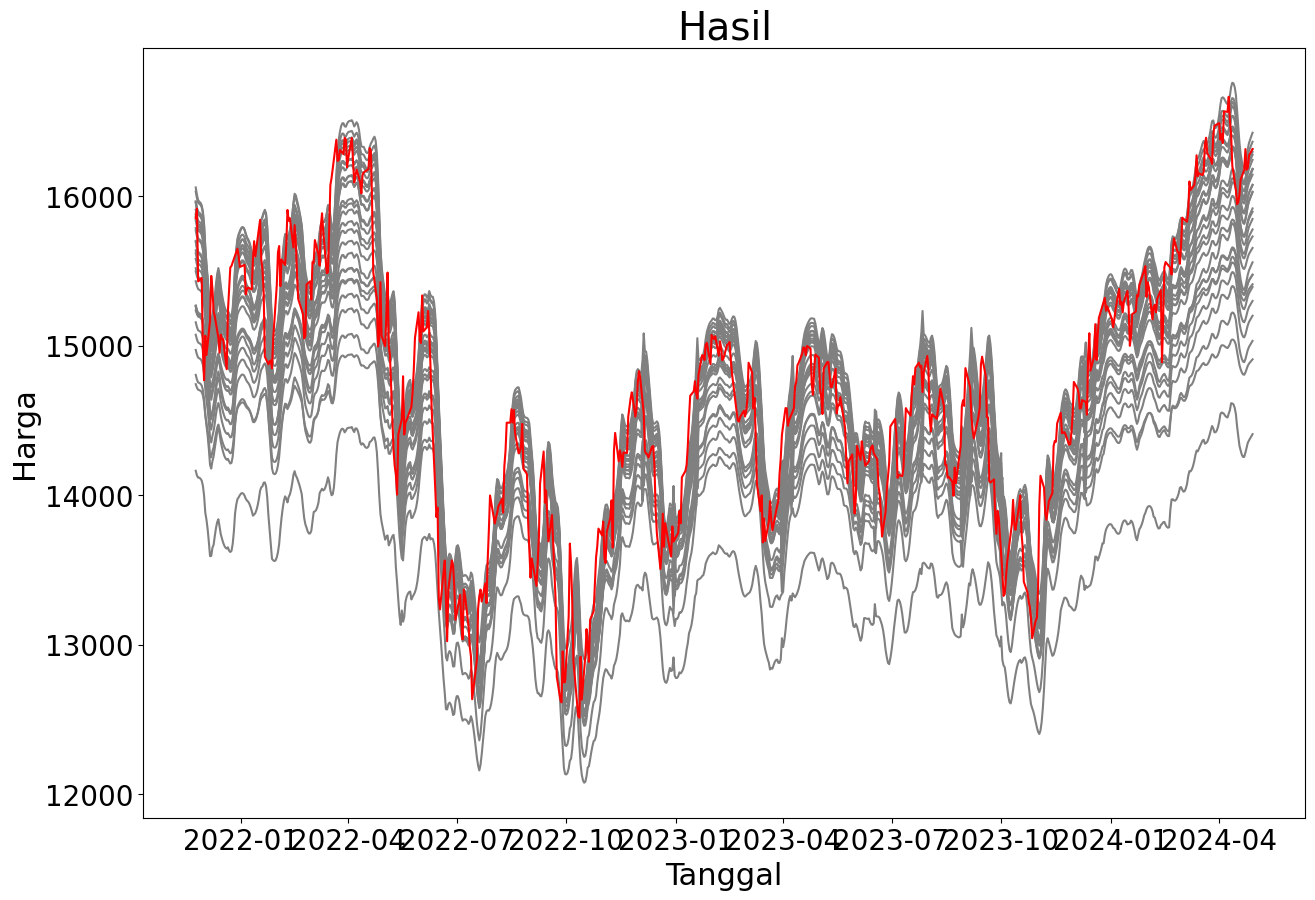

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_prediction_df.columns:
    if column != 'Rata2':
        ax.plot(bm_prediction_df.index, bm_prediction_df[column], label=column, color='gray')
ax.plot(bm_prediction_df.index ,y_test, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

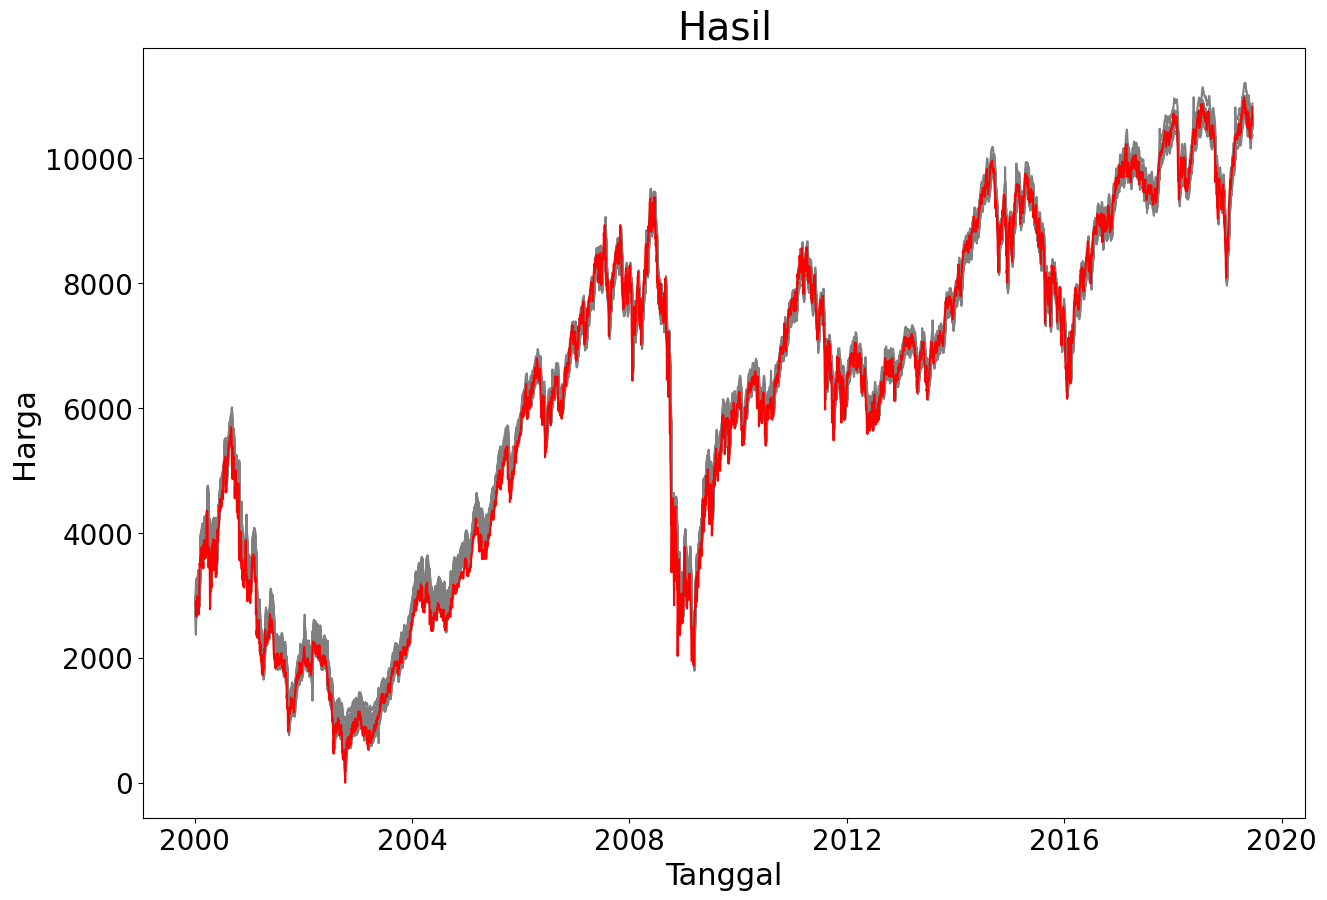

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
for column in bm_train_predictions.columns:
    if column != 'Rata2':
        ax.plot(bm_train_predictions.index, bm_train_predictions[column], label=column, color='gray')
ax.plot(bm_train_predictions.index ,y_train, label='Harga Asli', color='red')

ax.set_xlabel('Tanggal', fontsize=22)
ax.set_ylabel('Harga', fontsize=22)
ax.set_title('Hasil', fontsize=28)

ax.legend

ax.tick_params(axis='both', labelsize=20)

plt.show()

## LSTM dengan Input Harga Saham dan Keputusan Jual Beli

In [ ]:
datacopy = data_full[3:]
datacopy

In [ ]:
datacopy['EMA_50'] = datacopy['Close'].ewm(span=50, adjust=False).mean()
datacopy['EMA_200'] = datacopy['Close'].ewm(span=200, adjust=False).mean()
datacopy['Diff']= datacopy['EMA_50']-datacopy['EMA_200']
datacopy['sign'] = datacopy['Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
datacopy['sign_change'] = datacopy['sign'].diff().apply(lambda x: 1 if x != 0 else 0)
filter = datacopy[datacopy['sign_change'] == 1]
idx_datafull = filter.index
datacopy['label'] = np.where(
    (datacopy['sign'] == 1) & (datacopy['sign_change'] != 0), 'Sell',
    np.where((datacopy['sign'] == -1) & (datacopy['sign_change'] != 0), 'Buy', 'Keep')
)
check = datacopy[datacopy['sign_change'] != 0]
check

In [ ]:
datacopy['label1'] = datacopy['label'].apply(lambda x: -1 if x == 'Sell' else (1 if x == 'Buy' else 0))
datacopy
check = datacopy[datacopy['label1'] != 0]
check

In [ ]:
#data_full['Close'] = pd.to_numeric(datacopy['Close'])
#datacopy['label1'] = pd.to_numeric(datacopy['label1'])

X_actual, y_actual, dates_actual = windowed_df_close(datacopy[['Close','label1']],2)
banyakn = len(X_actual)
Mq_80 = int(banyakn * .8)
Mq_90 = int(banyakn * .9)
dates_actual_train, X_actual_train, y_actual_train = dates_actual[:Mq_80], X_actual[:Mq_80], y_actual[:Mq_80]
dates_actual_val, X_actual_val, y_actual_val = dates_actual[Mq_80:Mq_90], X_actual[Mq_80:Mq_90], y_actual[Mq_80:Mq_90]
dates_actual_test, X_actual_test, y_actual_test = dates_actual[Mq_90:], X_actual[Mq_90:], y_actual[Mq_90:]

In [ ]:
datacopy

In [ ]:
y_actual.shape

In [ ]:
from hyperopt import hp

space = {
    'hiddenLayerOne': hp.choice('hiddenLayerOne', [32, 64, 128]),
    'hiddenLayerTwo': hp.choice('hiddenLayerTwo', [32, 64, 128]),
    'activation': hp.choice('activation', ['tanh', 'relu']),
    'epochs': hp.choice('epochs',[50,100,150,200]),
    'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.01]),
    'dropout': hp.choice('dropout', [0.1, 0.2, 0.3]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

def objective(params):
    model = Sequential([
        LSTM(params['hiddenLayerOne'], activation=params['activation'], return_sequences=True, input_shape=(2, 2)),
        Dropout(params['dropout']),
        LSTM(params['hiddenLayerTwo'], activation=params['activation']),
        Dropout(params['dropout']),
        Dense(1, activation='linear')
    ])

    model.compile(optimizer=Adam(learning_rate=params['learning_rate']),
                  loss='mse',
                  metrics=['mean_absolute_error'])

    es = EarlyStopping(monitor='val_loss',mode='min',
                       verbose=1,patience=5)

    model.fit(X_actual_train, y_actual_train, batch_size=int(params['batch_size']),validation_data=(X_actual_val, y_actual_val))

    score, acc = model.evaluate(X_actual_val, y_actual_val, verbose=0)

    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params}

In [ ]:
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from hyperopt import hp, fmin, tpe, Trials, space_eval, STATUS_OK
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
trials = Trials()

In [ ]:
best_params = fmin(
  fn=objective,
  space=space,
  algo=tpe.suggest,
  max_evals=175,
  trials=trials)

In [ ]:
space_eval(space, best_params)

In [ ]:
LSTM_EMA_model = Sequential([
    layers.LSTM(32, activation = 'relu', return_sequences = True, input_shape = (2,2)),
    layers.Dropout(0.2),
    layers.LSTM(32,activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation = 'linear')
])

LSTM_EMA_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mean_absolute_error'],
)

LSTM_EMA_model.summary()

RUN

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    min_delta = 0.0001,
    restore_best_weights=True
)

In [ ]:
result = []
mapes = []
prediction_result = []
histories = []

for i in range(30):
    print(f"Training iteration {i+1}...")

    model = tf.keras.models.clone_model(LSTM_EMA_model)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss = 'mse',
        metrics = ['mean_absolute_error'],
    )

    history = model.fit(X_actual_train, y_actual_train, batch_size=128, validation_data=(X_actual_val, y_actual_val), epochs=50)

    result.append(history)
    histories.append(history.history)

    predictions = model.predict(X_actual_test).flatten()
    mape = mean_absolute_percentage_error(y_actual_test, predictions)
    prediction_result.append(predictions)
    mapes.append(mape)
    print(f"Iteration {i+1}: MAPE = {mape}")

In [ ]:
import numpy as np

all_train_loss = np.array([h['loss'] for h in histories])
all_val_loss = np.array([h['val_loss'] for h in histories])

mean_train_loss = np.mean(all_train_loss, axis=0)
mean_val_loss = np.mean(all_val_loss, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_train_loss, label='Rata-rata Training Loss')
plt.plot(mean_val_loss, label='Rata-rata Validation Loss')
plt.title('Rata-rata Loss per Epoch dari 30 Iterasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
prediction_df = pd.DataFrame(prediction_result).transpose()
prediction_df.index = dates_actual_test
prediction_df.columns = [f'Iterasi {i+1}' for i in range(prediction_df.shape[1])]
print(prediction_df)

In [ ]:
prediction_df2 = prediction_df.copy(deep=True)
print(prediction_df2)

In [ ]:
prediction_df2 = prediction_df2.multiply(range_value)
print(prediction_df2)

In [ ]:
y_test2 = y_actual_test * range_value
y_test2

In [ ]:
prediction_df2['Rata2'] = prediction_df2.mean(axis=1)
print(prediction_df2)

In [ ]:
from math import sqrt
hasil = prediction_df2['Rata2']
close_test_mae = mean_absolute_error(y_test2, hasil)
close_test_mse = mean_squared_error(y_test2, hasil)
close_test_rmse = sqrt(close_test_mse)
close_test_mape = mean_absolute_percentage_error(y_test2, hasil)
close_test_mae, close_test_mse, close_test_rmse, close_test_mape

In [ ]:
prediction_df2.to_csv('hasilprediksilstm2fit_INDO.csv')